In [2]:
import numpy as np
import scipy as sp
from astropy.io import fits
import matplotlib
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
import PIL
from PIL import Image
from scipy.ndimage import correlate
import matplotlib.colors as colors
from math import sqrt
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray
print('Import done')
from matplotlib.colors import LogNorm
from scipy.ndimage import gaussian_filter
from scipy.spatial import Delaunay
from scipy.spatial import cKDTree
from scipy.spatial import KDTree
from scipy.interpolate import griddata
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
print(sns.__version__)
#from resizeimage import resizeimage

Import done
0.10.1


In [3]:
def unique2d(a):
    x, y = a.T
    b = x + y*1.0j 
    idx = np.unique(b,return_index=True)[1]
    return a[idx] 

def do_kdtree(combined_x_y_arrays,points,k=1):
    mytree = cKDTree(combined_x_y_arrays)
    dist, indexes = mytree.query(points,k=k)
    return np.array(dist),np.array(indexes)


In [4]:
name="NGC6975"
#name="NGC2906"
#name="NGC4030"
file="MUSE/flux_elines."+name+".cube.fits.gz"
#file="MUSE/flux_elines.NGC4030.cube.fits.gz"
hdu=fits.open(file)
data=hdu[0].data
hdr=hdu[0].header
F_Ha_MUSE=data[20,:,:]
eF_Ha_MUSE=data[140,:,:]
F_WHa_MUSE=data[110,:,:]
cont_MUSE=(-1)*F_Ha_MUSE/F_WHa_MUSE
file_SSP="MUSE/"+name+".SSP.cube.fits.gz"
hdu=fits.open(file_SSP)
data=hdu[0].data
hdr=hdu[0].header
V_MUSE=data[0,:,:]
cont_SSP_MUSE=data[3,:,:]
e_cont_SSP_MUSE=data[4,:,:]
SN_SSP_MUSE=cont_SSP_MUSE/e_cont_SSP_MUSE

V_MUSE[V_MUSE==-1.0]=0.0
#print(hdr)

#print(V_MUSE)


In [5]:
file="CALIFA/NGC2906.Pipe3D.cube.fits.gz"
hdu=fits.open(file)
data=hdu[3].data
hdr=hdu[3].header
F_Ha_CAL=data[45,:,:]
eF_Ha_CAL=data[249,:,:]
data=hdu[1].data
hdr=hdu[1].header
V_CAL=data[0,:,:]
cont_SSP_CAL=data[3,:,:]
e_cont_SSP_CAL=data[4,:,:]
SN_SSP_CAL=cont_SSP_CAL/e_cont_SSP_CAL

In [6]:
a = np.linspace(1,10,3)
b = a**2
c = np.concatenate((a,b))
print(c)

[  1.     5.5   10.     1.    30.25 100.  ]


In [7]:
#
# MUSE
#

mask_F_Ha_neg = F_Ha_MUSE<0
F_Ha_MUSE_neg = F_Ha_MUSE [mask_F_Ha_neg]
F_Ha_MUSE_noise = np.concatenate((F_Ha_MUSE_neg,(-1)*F_Ha_MUSE_neg))
mean_F_Ha_MUSE_noise = np.mean(F_Ha_MUSE_noise)
std_F_Ha_MUSE_noise = np.std(F_Ha_MUSE_noise)
print ('MUSE = ',mean_F_Ha_MUSE_noise,std_F_Ha_MUSE_noise)
MUSE_1sig = std_F_Ha_MUSE_noise
MUSE_3sig = 3*MUSE_1sig
spax_sca_MUSE = 0.2
FWHM_MUSE = 1.0
FWHM_MUSE = FWHM_MUSE/spax_sca_MUSE

MUSE =  1.2893078906342545e-20 0.0015026861381936193


MUSE_neg =  0.0 0.0004324458648783838
MUSE_pos =  0.0005279652250465006 0.0001614589775037943
RAT = 2.846183928233664
1sig MUSE-V  0.0001614589775037943


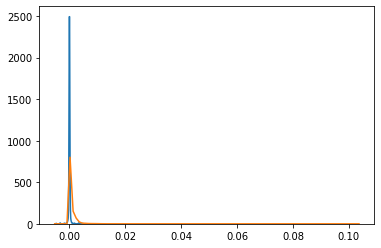

In [8]:
# MUSE
# g-band
mask_V_neg = V_MUSE<0
V_MUSE_neg = V_MUSE [mask_V_neg]
V_MUSE_pos = V_MUSE [~mask_V_neg]
V_MUSE_noise = np.concatenate((V_MUSE_neg,(-1)*V_MUSE_neg))
mean_V_MUSE_noise = np.mean(V_MUSE_noise)
std_V_MUSE_noise = np.std(V_MUSE_noise)
print ('MUSE_neg = ',mean_V_MUSE_noise,std_V_MUSE_noise)
MUSE_1sig_V = std_V_MUSE_noise
MUSE_3sig_V = 3*MUSE_1sig
median_V_MUSE_pos = np.median(V_MUSE_pos)
std_V_MUSE_pos = np.std(V_MUSE[V_MUSE<median_V_MUSE_pos])
median_V_MUSE = np.median(V_MUSE[V_MUSE<median_V_MUSE_pos])
print ('MUSE_pos = ',median_V_MUSE_pos,std_V_MUSE_pos)
rat = MUSE_1sig/median_V_MUSE_pos

print('RAT =',rat)
ax=sns.distplot(V_MUSE_noise, hist=False)
sns.distplot(V_MUSE, ax= ax, hist=False)

MUSE_1sig_V=np.min(np.array([MUSE_1sig_V,median_V_MUSE_pos,std_V_MUSE_pos,MUSE_1sig]))
#MUSE_1sig_V=np.min(np.array([MUSE_1sig_V,std_V_MUSE_pos]))
print('1sig MUSE-V ',MUSE_1sig_V)

MUSE_neg =  nan nan
MUSE_pos =  nan nan
RAT = nan
1sig MUSE-V  nan


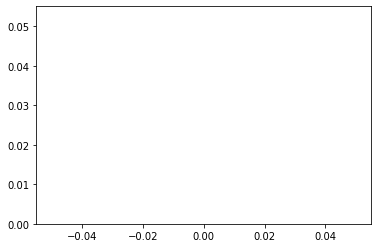

In [9]:
mask_cont_neg = cont_MUSE<0
cont_MUSE_neg = cont_MUSE [mask_cont_neg]
cont_MUSE_pos = cont_MUSE [~mask_cont_neg]
cont_MUSE_noise = np.concatenate((cont_MUSE_neg,(-1)*cont_MUSE_neg))
mean_cont_MUSE_noise = np.mean(cont_MUSE_noise)
std_cont_MUSE_noise = np.std(cont_MUSE_noise)
print ('MUSE_neg = ',mean_cont_MUSE_noise,std_cont_MUSE_noise)
MUSE_1sig_cont = std_cont_MUSE_noise
MUSE_3sig_cont = 3*MUSE_1sig
median_cont_MUSE_pos = np.median(cont_MUSE_pos)
std_cont_MUSE_pos = np.std(cont_MUSE[cont_MUSE<median_cont_MUSE_pos])
median_cont_MUSE = np.median(cont_MUSE[cont_MUSE<median_cont_MUSE_pos])
print ('MUSE_pos = ',median_cont_MUSE_pos,std_cont_MUSE_pos)
rat = MUSE_1sig/median_cont_MUSE_pos

print('RAT =',rat)
ax=sns.distplot(cont_MUSE_noise, hist=False)
sns.distplot(cont_MUSE, ax= ax, hist=False)

MUSE_1sig_cont=np.min(np.array([MUSE_1sig_cont,median_cont_MUSE_pos,std_cont_MUSE_pos,MUSE_1sig]))
#MUSE_1sig_cont=np.min(np.array([MUSE_1sig_cont,std_cont_MUSE_pos]))
print('1sig MUSE-V ',MUSE_1sig_cont)

In [10]:
#
# CAL
#

mask_F_Ha_neg = F_Ha_CAL<0
F_Ha_CAL_neg = F_Ha_CAL [mask_F_Ha_neg]
F_Ha_CAL_noise = np.concatenate((F_Ha_CAL_neg,(-1)*F_Ha_CAL_neg))
mean_F_Ha_CAL_noise = np.mean(F_Ha_CAL_noise)
std_F_Ha_CAL_noise = np.std(F_Ha_CAL_noise)
print ('CAL = ',mean_F_Ha_CAL_noise,std_F_Ha_CAL_noise)
CAL_1sig = std_F_Ha_CAL_noise
CAL_3sig = 3*CAL_1sig
spax_sca_CAL = 1.0
FWHM_CAL = 2.5
FWHM_CAL = FWHM_CAL/spax_sca_CAL

CAL =  0.0 0.03259411442675947


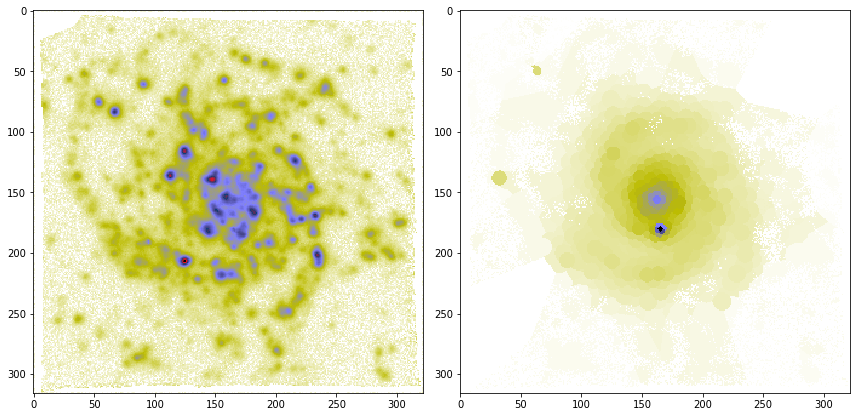

In [11]:
#
#
#
F_Ha_MUSE_g=gaussian_filter(F_Ha_MUSE, sigma=20*FWHM_MUSE)
mask_MUSE = F_Ha_MUSE_g<2*MUSE_1sig
F_Ha_MUSE_masked = np.ma.masked_invalid(F_Ha_MUSE)
F_Ha_MUSE_masked = np.ma.array(F_Ha_MUSE_masked, mask = mask_MUSE, fill_value=0.0)
F_Ha_MUSE_fill = F_Ha_MUSE_masked.filled()

F_Ha_CAL_g=gaussian_filter(F_Ha_CAL, sigma=20*FWHM_CAL)
mask_CAL = F_Ha_CAL_g<2*CAL_1sig
F_Ha_CAL_masked = np.ma.array(F_Ha_CAL, mask = mask_CAL, fill_value=0.0)
F_Ha_CAL_fill = F_Ha_CAL_masked.filled()


#print(F_Ha_MUSE_masked)

#fig, axes = plt.subplots(2,1, figsize=(12,24))
fig, axes = plt.subplots(1,2, figsize=(12,6))

cont_MUSE = np.ma.masked_invalid(cont_MUSE)
cmap='gist_stern_r'
axes[0].imshow(np.sqrt(F_Ha_MUSE), interpolation='none',\
               cmap=cmap) 
axes[1].imshow(np.sqrt(cont_MUSE), interpolation='none',\
               cmap=cmap) 
#print(cont_MUSE[50:150,50:150])
               #vmin=-0.5*MUSE_1sig, vmax=300*MUSE_1sig)
#axes[1].imshow(np.sqrt(F_Ha_CAL), interpolation='none',\
#               cmap=cmap)

plt.tight_layout()
plt.show()

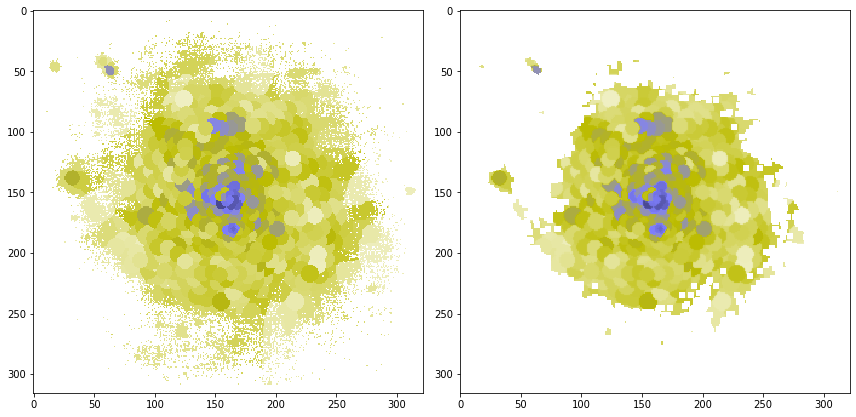

In [12]:
fig, axes = plt.subplots(1,2, figsize=(12,6))
SN_SSP_MUSE_g=gaussian_filter(SN_SSP_MUSE, sigma=0.5)
cmap='gist_stern_r'
axes[0].imshow(SN_SSP_MUSE, interpolation='none',\
               cmap=cmap,vmin=-1,vmax=50) 
               #vmin=-0.5*MUSE_1sig, vmax=300*MUSE_1sig)
axes[1].imshow(SN_SSP_MUSE_g, interpolation='none',\
               cmap=cmap,vmin=-1,vmax=50)

plt.tight_layout()
plt.show()

In [12]:
#
# Core functions to run HIIblob
#

def forward(x):
    return x**(1/2)


def inverse(x):
    return x**2

def gaus2d(x=0, y=0, mx=0, my=0, sx=1, sy=1):
    return 1. / (2. * np.pi * sx * sy) * np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))


def extract_flux(blobs,image,kind=0,we=0,dr=3):
# kind = 0 SUM
# kind = 1 MEAN
# kind = 2 VAR

# we = 0 No Weight
# we = 1 Gaussian Weight
# we = 2 Gaussian quadration Weight
    n=len(blobs)
    (nx,ny) = image.shape
    image = np.ma.masked_invalid(image)
    flux = np.zeros(n)
    i=0
    for blob in blobs:
        y, x, r = blob
        flux_now = 0
        i0=int(x-dr*r)
        i1=int(x+dr*r)
        j0=int(y-dr*r)
        j1=int(y+dr*r)
        if (i0<0):
            i0=0
        if (j0<0):
            j0=0
        if (i1>(nx-1)):
            i1=nx-1
        if (j1>(ny-1)):
            j1=ny-1
        image_sec=image[j0:j1,i0:i1] 
        (ny_sec,nx_sec)=image_sec.shape
        x_g = np.arange(0,nx_sec,1)
        y_g = np.arange(0,ny_sec,1)
        x_g, y_g = np.meshgrid(x_g, y_g) # get 2D variables instead of 1D
        xp_g = x-i0
        yp_g = y-j0
#
# No weight!
#
        w_l = np.ones((ny_sec,nx_sec))
        dist = np.sqrt((x_g-xp_g)**2+(y_g-yp_g)**2)
        w_l[dist>r]=0
        
#
# r<r_HII -> w_l = 0
#

        w_g = gaus2d(x_g, y_g, mx=xp_g, my=yp_g,sx=r, sy=r)
        w_g[dist>2*r]=0
        
# WE = 2
        w_q = w_g**4
        w_q[dist>2*r]=0
        
        if (we==0):
            w=w_l
        if (we==1):
            w=w_g
        if (we==2):
            w=w_q
            
        #        print(w_g)
        #print(w.shape,w_g.shape)
        #
        # SUM
        #
        if (kind==0):
            flux_now=np.ma.sum(image_sec*w)
            w_now=np.sum(w)
            flux_now /= w_now
            flux_now *= (nx_sec*ny_sec)
        #
        # MEAN
        #
        if (kind==1):
            flux_now=np.ma.sum(image_sec*w)
            w_now=np.sum(w)
            flux_now /= w_now
        #
        # STDDED
        #
        flux[i]=flux_now
        i=i+1
    return flux

#fluxMUSE_1sig_V=np.min(np.array([MUSE_1sig_V,median_V_MUSE_pos,std_V_MUSE_pos,MUSE_1sig]))
#MUSE_1sig_V=np.min(np.array([MUSE_1sig_V,std_V_MUSE_pos]))
#print('1sig MUSE-V ',MUSE_1sig_V)

def extract_flux_points(points,r_points,image,kind=0,we=0,dr=3):
# kind = 0 SUM
# kind = 1 MEAN
# kind = 2 VAR

# we = 0 No Weight
# we = 1 Gaussian Weight
# we = 2 Gaussian to the power of 2 Weight
    n=len(points)
    (nx,ny) = image.shape
    image = np.ma.masked_invalid(image)
    flux = np.zeros(n)
    i=0
    for blob,r in zip(points,r_points):
        y, x = blob
        flux_now = 0
        i0=int(x-dr*r)
        i1=int(x+dr*r)
        j0=int(y-dr*r)
        j1=int(y+dr*r)
        if (i0<0):
            i0=0
        if (j0<0):
            j0=0
        if (i1>(nx-1)):
            i1=nx-1
        if (j1>(ny-1)):
            j1=ny-1
        image_sec=image[j0:j1,i0:i1] 
        (ny_sec,nx_sec)=image_sec.shape
        x_g = np.arange(0,nx_sec,1)
        y_g = np.arange(0,ny_sec,1)
        x_g, y_g = np.meshgrid(x_g, y_g) # get 2D variables instead of 1D
        xp_g = x-i0
        yp_g = y-j0
        w_l = np.ones((ny_sec,nx_sec))
        dist = np.sqrt((x_g-xp_g)**2+(y_g-yp_g)**2)
        w_l[dist>r]=0
        
#
# r<r_HII -> w_l = 0
#

        w_g = gaus2d(x_g, y_g, mx=xp_g, my=yp_g,sx=r, sy=r)
        w_g[dist>2*r]=0
        
# WE = 2
        w_q = w_g**4
        w_q[dist>2*r]=0
        
        if (we==0):
            w=w_l
        if (we==1):
            w=w_g
        if (we==2):
            w=w_q
            
        #        print(w_g)
        #print(w.shape,w_g.shape)
        if (kind==0):
            flux_now=np.ma.sum(image_sec*w)
            w_now=np.sum(w)
            flux_now /= w_now
            flux_now *= (nx_sec*ny_sec)
        if (kind==1):
            flux_now=np.ma.sum(image_sec*w)
            w_now=np.sum(w)
            flux_now /= w_now
        flux[i]=flux_now
        i=i+1
    return flux
        
def create_HII_image(blobs,flux,nx,ny,dr=5):
    image = np.zeros((ny,nx))
    for blob,bflux in zip(blobs,flux):
        y, x, r = blob
        i0=int(x-dr*r)
        i1=int(x+dr*r)
        j0=int(y-dr*r)
        j1=int(y+dr*r)
        if (i0<0):
            i0=0
        if (j0<0):
            j0=0
        if (i1>(nx-1)):
            i1=nx-1
        if (j1>(ny-1)):
            j1=ny-1
        image_sec=image[j0:j1,i0:i1] 
        (ny_sec,nx_sec)=image_sec.shape
        x_g = np.arange(0,nx_sec,1)
        y_g = np.arange(0,ny_sec,1)        
        x_g, y_g = np.meshgrid(x_g, y_g) # get 2D variables instead of 1D
        xp_g = x-i0
        yp_g = y-j0
        w_g = gaus2d(x_g, y_g, mx=xp_g, my=yp_g,sx=r, sy=r)
#        w_g = gaus2d(x_g, y_g, sx=r, sy=r)
        image_HII = bflux*w_g/(2*np.pi)
        image[j0:j1,i0:i1]=image[j0:j1,i0:i1]+image_HII
    return image


def delta_HII_image_to_fit(org_img,blobs,nx,ny,dr=5): 
    def delta_img(x, *flux): 
        model_img=create_HII_image(blobs,flux,nx,ny,dr=dr)
        delta = np.nansum((org_img-model_img)**2/org_img)
        return delta
    return delta_img

def HII_image_to_fit(blobs,nx,ny,dr=5): 
    def delta_img(x, *flux): 
        model_img=create_HII_image(blobs,flux,nx,ny,dr=dr)
        return model_img
    return delta_img

def flatten_HII_image_to_fit(blobs,nx,ny,dr=5): 
    def delta_img(x, *flux): 
        model_img=create_HII_image(blobs,flux,nx,ny,dr=dr)
        return model_img.flatten()
    return delta_img

def ravel_HII_image_to_fit(blobs,nx,ny,dr=5): 
    def delta_img(x, *flux): 
        model_img=create_HII_image(blobs,flux,nx,ny,dr=dr)
        return model_img.ravel()
    return delta_img

def ravel_Gauss_HII_img(xdata, *flux):
    global BLOBS
    global NX
    global NY
    global DR
    model_img=create_HII_image(BLOBS,flux,NX,NY,dr=DR)
    return model_img.ravel()




In [13]:
#
# We need an Halpha and a continuum image to detect the Hii regions
#

spax_sca_MUSE = 0.2
FWHM_MUSE = 1.0
FWHM_MUSE = FWHM_MUSE/spax_sca_MUSE


def create_diff(Ha_image,blobs_log_MUSE,FWHM_MUSE):
    #
    # We select those regions far away from the Hii regions
    #
    (nx,ny)=Ha_image.shape
    points_MUSE=blobs_log_MUSE[:,0:2]
    tri_MUSE = Delaunay(points_MUSE)
    diff_p_MUSE = np.zeros((len(tri_MUSE.simplices),2))
    r_p_MUSE = np.zeros(len(tri_MUSE.simplices))
    i=0
    for j, s in enumerate(tri_MUSE.simplices):
        p = points_MUSE[s].mean(axis=0)
        diff_p_MUSE[s,0]=p[0]
        diff_p_MUSE[s,1]=p[1]
    #
    # We remove repeated points in the diffuse 
    #
    diff_p_MUSE = unique2d(diff_p_MUSE)
    #
    # We remove the diffse too near to an Hii region
    #
    dist_HII_diff,index_HII_diff = do_kdtree(blobs_log_MUSE[:,0:2],diff_p_MUSE)
    mask_HII_diff = dist_HII_diff>2*blobs_log_MUSE[index_HII_diff,2]
    diff_p_MUSE = diff_p_MUSE[mask_HII_diff]
    #
    # We extract aperture of FWHMN (mean), around the diffse points
    #
    r_p_MUSE=FWHM_MUSE*np.ones(len(diff_p_MUSE))
    F_Ha_diff_MUSE=extract_flux_points(diff_p_MUSE,r_p_MUSE,Ha_image,kind=1,we=2)    
    xgrid=np.arange(0, ny, 1)
    ygrid=np.arange(0, nx, 1)
    Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
    new_array=np.array((diff_p_MUSE[:,1],diff_p_MUSE[:,0])).T
    diff_interp_map = griddata(new_array, F_Ha_diff_MUSE, (Xgrid, Ygrid), method='nearest')
    diff_interp_map_g=gaussian_filter(diff_interp_map, sigma=1.5*FWHM_MUSE)
    return diff_interp_map_g

def HIIextraction(Ha_image,blobs_log_MUSE,kind=0,we=2):
    """
    
    """
    (nx,ny)=Ha_image.shape
    #
    # Extract flux of Hii regions!
    #
    blobs_F_Ha=extract_flux(blobs_log_MUSE,Ha_image,kind=kind,we=we)    
    #
    # Create image of HII_regions
    #
    image_HII=create_HII_image(blobs_log_MUSE,blobs_F_Ha,ny,nx)
    #
    # Image clean from HII model
    #
    image_clean_HII = Ha_image-image_HII
    image_clean_HII_g=gaussian_filter(image_clean_HII, sigma=2*FWHM_MUSE)    
    diff_interp_map_g=create_diff(Ha_image,blobs_log_MUSE,FWHM_MUSE)
    return blobs_F_Ha,image_HII,diff_interp_map_g

def HIIdetection(Ha_image,min_sigma=0.8, max_sigma=2.0, num_sigma=30, threshold=20):
    """
    
    """
    (nx,ny)=Ha_image.shape
    #
    # Detect Hii regions!
    #
    blobs_log_MUSE = blob_log(Ha_image, min_sigma=min_sigma,\
                          max_sigma=max_sigma,\
                          num_sigma=num_sigma, threshold=threshold)
    blobs_log_MUSE[:, 2] = blobs_log_MUSE[:, 2] * sqrt(2) #1.75 #sqrt(2) #1.75 #sqrt(2)
    #
    # Extract flux of Hii regions!
    #
    blobs_F_Ha=extract_flux(blobs_log_MUSE,Ha_image,kind=0,we=2)    
    #
    # Create image of HII_regions
    #
    image_HII=create_HII_image(blobs_log_MUSE,blobs_F_Ha,ny,nx)
    #
    # Image clean from HII model
    #
    image_clean_HII = Ha_image-image_HII
    image_clean_HII_g=gaussian_filter(image_clean_HII, sigma=2*FWHM_MUSE)    
    
    diff_interp_map_g=create_diff(image_clean_HII_g,blobs_log_MUSE,FWHM_MUSE)

    #print('# Diff = ',len(diff_p_MUSE))
    return blobs_log_MUSE,blobs_F_Ha,image_HII,diff_interp_map_g

def HIIblob(F_Ha_MUSE,V_MUSE,FWHM_MUSE, MUSE_1sig=0, MUSE_1sig_V=0, plot=0):
    #min_sigma=0.8, max_sigma=2.0,\
    #                            num_sigma=30,):
    """
        Parameters
        ----------
        F_Ha_MUSE : 2D array image 
            The Ha intensity map
        V_MUSE : 2D array image
            Continuum map image
        FWHM : float
            FWHM of the image
            
    """
    (nx,ny)=F_Ha_MUSE.shape
#
# Ha map statistics
#
    if (MUSE_1sig == 0):
        mask_F_Ha_neg = F_Ha_MUSE<0
        F_Ha_MUSE_neg = F_Ha_MUSE [mask_F_Ha_neg]
        F_Ha_MUSE_noise = np.concatenate((F_Ha_MUSE_neg,(-1)*F_Ha_MUSE_neg))
        mean_F_Ha_MUSE_noise = np.mean(F_Ha_MUSE_noise)
        std_F_Ha_MUSE_noise = np.std(F_Ha_MUSE_noise)
        MUSE_1sig = std_F_Ha_MUSE_noise
        MUSE_3sig = 3*MUSE_1sig

# MUSE
# g-band
    if (MUSE_1sig_V == 0):
        mask_V_neg = V_MUSE<0
        V_MUSE_neg = V_MUSE [mask_V_neg]
        V_MUSE_pos = V_MUSE [~mask_V_neg]
        V_MUSE_noise = np.concatenate((V_MUSE_neg,(-1)*V_MUSE_neg))
        mean_V_MUSE_noise = np.mean(V_MUSE_noise)
        std_V_MUSE_noise = np.std(V_MUSE_noise)
        MUSE_1sig_V = std_V_MUSE_noise
        MUSE_3sig_V = 3*MUSE_1sig
        median_V_MUSE_pos = np.median(V_MUSE_pos)
        std_V_MUSE_pos = np.std(V_MUSE[V_MUSE<median_V_MUSE_pos])
        median_V_MUSE = np.median(V_MUSE[V_MUSE<median_V_MUSE_pos])
        MUSE_1sig_V=np.min(np.array([MUSE_1sig_V,median_V_MUSE_pos,std_V_MUSE_pos,MUSE_1sig]))

    print('1sig Ha-map = ',MUSE_1sig,'; 1sig MUSE-V ',MUSE_1sig_V)


        
    #
    # We clean the invalid points
    #
    F_Ha_MUSE = np.ma.masked_invalid(F_Ha_MUSE)
    V_MUSE = np.ma.masked_invalid(V_MUSE)
    F_Ha_MUSE_g=gaussian_filter(F_Ha_MUSE, sigma=2*FWHM_MUSE)
    V_MUSE_g=gaussian_filter(V_MUSE, sigma=2*FWHM_MUSE)
    mask_MUSE = (F_Ha_MUSE_g<2*MUSE_1sig) | (V_MUSE_g<0.5*MUSE_1sig_V) 
    F_Ha_MUSE_masked = np.ma.array(F_Ha_MUSE, mask = mask_MUSE, fill_value=0.0)
    F_Ha_MUSE_fill = F_Ha_MUSE_masked.filled()

    #
    # Initial detection
    #
    blobs_log_MUSE,blobs_F_Ha,image_HII,diff_map=HIIdetection(F_Ha_MUSE_fill, min_sigma=0.8, max_sigma=2.0,\
                                num_sigma=30, threshold=1.5*MUSE_1sig)

    print('# HII reg. Initial = ',len(blobs_log_MUSE))
    #
    # We now subtract the diffuse and we detect HII regions again!
    #
    F_Ha_MUSE_clean = F_Ha_MUSE_fill-diff_map
    F_Ha_MUSE_masked = np.ma.array(F_Ha_MUSE_clean, mask = mask_MUSE, fill_value=0.0)
    F_Ha_MUSE_fill = F_Ha_MUSE_masked.filled()    
    blobs_log_MUSE,blobs_F_Ha,image_HII,diff_map_2=HIIdetection(F_Ha_MUSE_fill, min_sigma=0.8, max_sigma=2.0,\
                                num_sigma=30, threshold=2.0*MUSE_1sig)
    print('# HII reg. 2nd = ',len(blobs_log_MUSE))
    diff_map = create_diff(F_Ha_MUSE_fill,blobs_log_MUSE,FWHM_MUSE)    
    res_map = F_Ha_MUSE-(image_HII+diff_map)
    
    #
    # We find extra regions?
    #
    blobs_log_MUSE_add,blobs_F_Ha_add,\
    image_HII_add,diff_map_add=HIIdetection(res_map, min_sigma=0.8, max_sigma=2.0,\
                                            num_sigma=30, threshold=5.0*MUSE_1sig)
    print('# HII reg. additional = ',len(blobs_log_MUSE_add))
    #  
    # Look for the 2nd more near point
    #
    dist_HII_self,index_HII_self = do_kdtree(blobs_log_MUSE[:,0:2],blobs_log_MUSE_add[:,0:2],k=1)
    mask_HII_self = (dist_HII_self>blobs_log_MUSE_add[:,2]) 
    blobs_log_MUSE_add = blobs_log_MUSE_add[mask_HII_self]        
    blobs_final=np.concatenate((blobs_log_MUSE,blobs_log_MUSE_add), axis=0)
    


    
    #
    # Final Extraction
    #
    blobs_F_Ha,image_HII,diff_map_final=HIIextraction(F_Ha_MUSE_fill,blobs_final,kind=0,we=2)
    order=np.argsort(-1*blobs_F_Ha)
    blobs_F_Ha = blobs_F_Ha[order]
    blobs_final = blobs_final[order]
    
    res_map = F_Ha_MUSE-(image_HII+diff_map)
    X_sqr = (res_map**2)/np.abs(F_Ha_MUSE)
    X_sqr_masked = np.ma.array(X_sqr, mask = mask_MUSE, fill_value=0.0)
    X_sqr_sum = np.ma.sum(X_sqr_masked)/(len(blobs_F_Ha))
    print('# X_sqr = ',X_sqr_sum)
#    print(dist_HII_self)
    #
    # Mask regions that are inside another!
    #            x_g = np.arange(0,nx_sec,1)
    #    y_g = np.arange(0,ny_sec,1)  
    print('# HII reg clean=',len(blobs_final))
    
    #
    # Lets make some plots!
    #
    if (plot==1):
        fig, axes = plt.subplots(2,2, figsize=(15,15))
        cmap='gist_stern_r'
        im_Ha_MUSE=axes[0][0].imshow(F_Ha_MUSE, interpolation='none',\
                                     cmap=cmap, label=r'H$\alpha$',\
                                     norm=colors.PowerNorm(gamma=0.5)) 
        for blob in blobs_final:
            y, x, r = blob
            c = plt.Circle((x, y), r, color='darkred', linewidth=2, fill=False, alpha=0.25)
            axes[0][0].add_patch(c)
#        for blob in blobs_log_MUSE:
#            y, x, r = blob
#            c = plt.Circle((x, y), r, color='black', linewidth=2, fill=False, alpha=0.15)
#           axes[0][0].add_patch(c)
#        axes[0][0].scatter(blobs_log_MUSE[:,1],blobs_log_MUSE[:,0],s=blobs_log_MUSE[:,2]*20,\
#                           marker='+',edgecolor='blue',color='black',alpha=0.3)
        
        clim=im_Ha_MUSE.properties()['clim']
        im_HII_mod=axes[0][1].imshow(image_HII, interpolation='none',\
                                     cmap=cmap, label=r'Hii regions',\
                                     norm=colors.PowerNorm(gamma=0.5),clim=clim) 
        im_diff=axes[1][0].imshow(diff_map, interpolation='none',\
                                     cmap=cmap, label=r'Diffuse',\
                                  norm=colors.PowerNorm(gamma=0.5),clim=clim) 
        im_res=axes[1][1].imshow(res_map, interpolation='none',\
                                     cmap=cmap, label=r'Diffuse',\
                                 norm=colors.PowerNorm(gamma=0.5),clim=clim) 
        axes[0][0].set_xlim(0,nx)
        axes[0][0].set_ylim(0,ny)
        axes[0][1].set_xlim(0,nx)
        axes[0][1].set_ylim(0,ny)
        axes[1][0].set_xlim(0,nx)
        axes[1][0].set_ylim(0,ny)
        axes[1][1].set_xlim(0,nx)
        axes[1][1].set_ylim(0,ny)
        plt.show()

    return blobs_final,blobs_F_Ha,image_HII,diff_map_final



1sig Ha-map =  0.0015026861381936193 ; 1sig MUSE-V  0.0001614589775037943
# HII reg. Initial =  1222
# HII reg. 2nd =  595
# HII reg. additional =  199
# X_sqr =  1.4763767002699082
# HII reg clean= 713


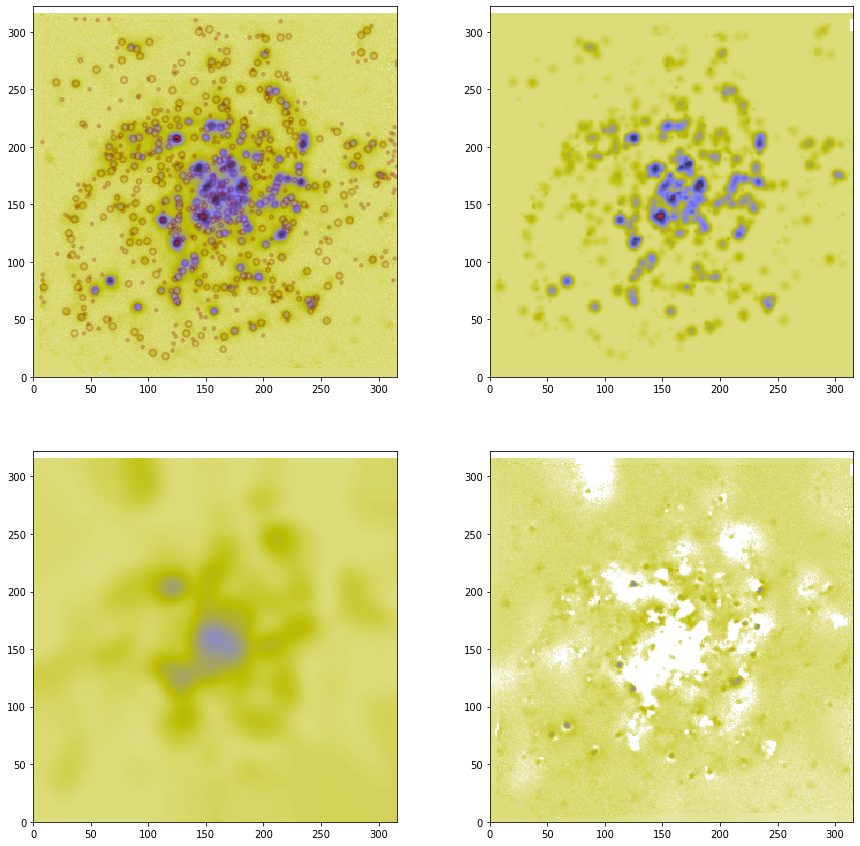

In [14]:
#        x_g = np.arange(0,nx_sec,1)
#        y_g = np.arange(0,ny_sec,1)  #    tri_MUSE = Delaunay(points_MUSE)
#    diff_p_MUSE = np.zeros((len(tri_MUSE.simplices),2))


##################################################################
# Running the script!
name="NGC6975"
#name="NGC2906"
#name="NGC4030"
file="MUSE/flux_elines."+name+".cube.fits.gz"
#file="MUSE/flux_elines.NGC4030.cube.fits.gz"
hdu=fits.open(file)
data=hdu[0].data
hdr=hdu[0].header
F_Ha_MUSE=data[20,:,:]
eF_Ha_MUSE=data[140,:,:]
F_WHa_MUSE=data[110,:,:]
file_SSP="MUSE/"+name+".SSP.cube.fits.gz"
hdu=fits.open(file_SSP)
data=hdu[0].data
hdr=hdu[0].header
V_MUSE=data[0,:,:]
V_MUSE[V_MUSE==-1.0]=0.0

blobs_final,blobs_F_Ha,image_HII,diff_map_final=HIIblob(F_Ha_MUSE,V_MUSE,\
                                                        FWHM_MUSE, MUSE_1sig=0, MUSE_1sig_V=0, plot=1)




<IPython.core.display.Javascript object>


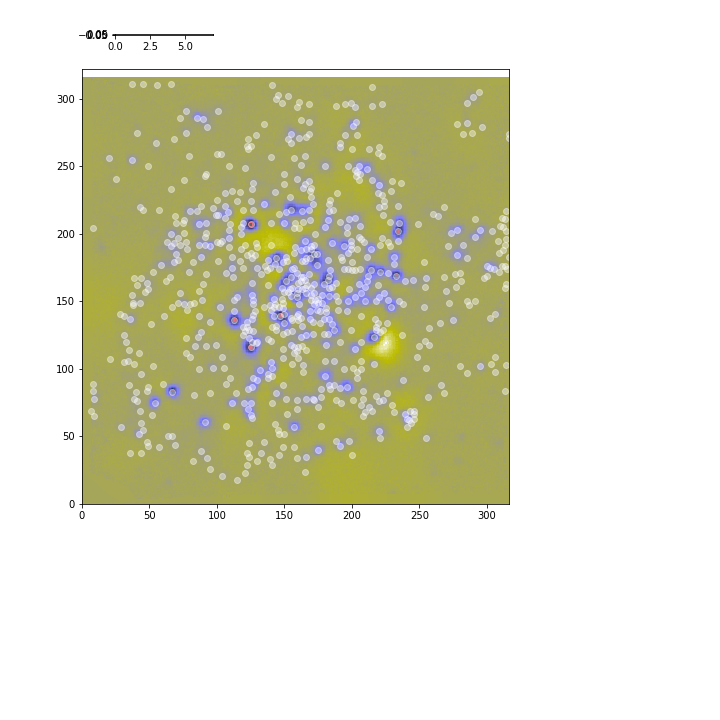

[109.9408501   89.89941674  95.00088788  91.2358997   82.80471992
  76.32510639  59.75139788  65.69876652  73.89816906  58.96124032]


In [16]:
#
# Extraction removing nearby regions
#
def extract_flux_refined(blobs,image,kind=0,we=0,dr=3,plot=0):
# kind = 0 SUM
# kind = 1 MEAN
# kind = 2 VAR

# we = 0 No Weight
# we = 1 Gaussian Weight
# we = 2 Gaussian quadration Weight
    n=len(blobs)
    (nx,ny) = image.shape
    image = np.ma.masked_invalid(image)
    flux = np.zeros(n)
    i=0
    
    if (plot==1):
        fig = plt.figure(figsize=(8,8))
        fig.canvas.set_window_title('Canvas active title')
#        gs = fig.add_gridspec(1, 2)
#        ax1 = fig.add_subplot(gs[0, 1])
#        ax2 = fig.add_subplot(gs[0, 0])
        ax2 = fig.add_subplot(111)
        cmap='gist_stern_r'
        im_Ha_MUSE=ax2.imshow(image, interpolation='none',\
                              cmap=cmap, label=r'H$\alpha$',\
                              norm=colors.PowerNorm(gamma=0.5)) 
        clim=im_Ha_MUSE.properties()['clim']
        ax2.set_xlim(0,nx)
        ax2.set_ylim(0,ny)
        ax1 = fig.add_axes([0.2, 0.9, 0.17, 0.08]) 
        
        
#        ax1 = fig.add_subplot(111)
#        ax2 = fig.add_subplot(121)

    for blob in blobs:
        y, x, r = blob
        flux_now = 0
        i0=int(x-dr*r)
        i1=int(x+dr*r)
        j0=int(y-dr*r)
        j1=int(y+dr*r)
        if (i0<0):
            i0=0
        if (j0<0):
            j0=0
        if (i1>(nx-1)):
            i1=nx-1
        if (j1>(ny-1)):
            j1=ny-1
        image_sec=image[j0:j1,i0:i1] 
        (ny_sec,nx_sec)=image_sec.shape
        x_g = np.arange(0,nx_sec,1)
        y_g = np.arange(0,ny_sec,1)
        x_g, y_g = np.meshgrid(x_g, y_g) # get 2D variables instead of 1D
        xp_g = x-i0
        yp_g = y-j0
#
# No weight!
#
        w_l = np.ones((ny_sec,nx_sec))
        dist = np.sqrt((x_g-xp_g)**2+(y_g-yp_g)**2)
        w_l[dist>r]=0
        
#
# r<r_HII -> w_l = 0
#

        w_g = gaus2d(x_g, y_g, mx=xp_g, my=yp_g,sx=r, sy=r)
        w_g[dist>2*r]=0
        
# WE = 2
        w_q = w_g**4
        w_q[dist>2*r]=0
        
        if (we==0):
            w=w_l
        if (we==1):
            w=w_g
        if (we==2):
            w=w_q
            
        #        print(w_g)
        #print(w.shape,w_g.shape)
        #
        # SUM
        #
        if (kind==0):
            flux_now=np.ma.sum(image_sec*w)
            w_now=np.sum(w)
            flux_now /= w_now
            flux_now *= (nx_sec*ny_sec)
        #
        # MEAN
        #
        if (kind==1):
            flux_now=np.ma.sum(image_sec*w)
            w_now=np.sum(w)
            flux_now /= w_now
        #
        # STDDED
        #
        flux[i]=flux_now
        i=i+1


        if (plot==1):            
            ax1.cla()
            im_sec=ax1.imshow(image_sec, interpolation='none',\
                                     cmap=cmap, label=r'H$\alpha$',\
                                     norm=colors.PowerNorm(gamma=0.5),\
                                     clim=clim) 
            nx_sec = j1-j0
            ny_sec = i1-i0
            ax1.set_xlim(0,nx_sec)
            ax1.set_ylim(0,ny_sec)
            mark = ax2.plot(x,y,'ro', color='white', alpha=0.4) #scatter(x,y,alpha=0.2)
            
            fig.canvas.draw()

#            for blob in blobs_final:
#                y, x, r = blob
#                c = plt.Circle((x, y), r, color='darkred', linewidth=2, fill=False, alpha=0.25)
#                axes[0][0].add_patch(c)
        
        
    return flux
F_Ha_MUSE_clean = F_Ha_MUSE-diff_map_final
#blobs_final,blobs_F_Ha,image_HII,diff_map_final=HIIblob(F_Ha_MUSE,V_MUSE,\
#                                                        FWHM_MUSE, MUSE_1sig=0, MUSE_1sig_V=0, plot=1)
%matplotlib notebook
blobs_F_Ha_refined=extract_flux_refined(blobs_final,F_Ha_MUSE_clean,kind=0,we=2, plot=1)    
print(blobs_F_Ha_refined[0:10])
%matplotlib inline

#print(blobs_final[0:10])
#print(blobs_F_Ha[0:10])
#print(blobs_final_sorted[0:10])
#print(blobs_F_Ha_sorted[0:10])
#sortedArr = arr2D[arr2D[:,columnIndex].argsort()]

In [ ]:
#blobs_final,blobs_F_Ha,image_HII,diff_map_final=HIIblob(F_Ha_MUSE,V_MUSE,FWHM_MUSE, MUSE_1sig=0, MUSE_1sig_V=0, plot=1)
plt.figure(figsize=[10,8])
#x = 0.3*np.random.randn(1000)
#y = 0.3*np.random.randn(1000)
x = F_Ha_MUSE.ravel()
res_img = F_Ha_MUSE-(image_HII+diff_map_final)
#n, bins, patches = plt.hist([F_Ha_MUSE, F_Ha_MUSE-(image_HII+diff_map_final)])
n, bins, patches = plt.hist([x,res_img.ravel()],bins=50, range=(-0.05,0.05), density=True)

#ax_hist_MUSE=sns.distplot(F_Ha_MUSE, hist=False)
#sns.distplot(F_Ha_MUSE-(image_HII+diff_map_final), ax=ax_hist_MUSE, hist=False)
#=sns.distplot(F_Ha_MUSE, ax=ax_hist_MUSE, hist=False)

<AxesSubplot:>

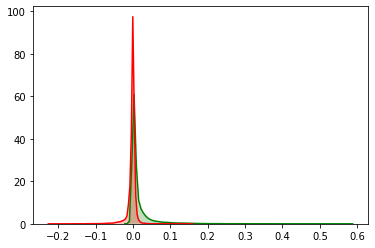

In [44]:
#blobs_final,blobs_F_Ha,image_HII,diff_map_final=HIIblob(F_Ha_MUSE,V_MUSE,FWHM_MUSE, MUSE_1sig=0, MUSE_1sig_V=0, plot=1)


#plt.figure(figsize=[10,8])
#x = 0.3*np.random.randn(1000)
#y = 0.3*np.random.randn(1000)
x = F_Ha_MUSE.ravel()
res_img = F_Ha_MUSE-(image_HII+diff_map_final)
#n, bins, patches = plt.hist([F_Ha_MUSE, F_Ha_MUSE-(image_HII+diff_map_final)])
#sns.displot([x,res_img.ravel()], kind="kde", fill=True)
ax_hist_MUSE=sns.distplot(F_Ha_MUSE, hist=False, color="g", kde_kws={"shade": True})
sns.distplot(res_img, hist=False, color="r", kde_kws={"shade": True}, ax = ax_hist_MUSE)
#n, bins, patches = plt.hist([x,res_img.ravel()],bins=50, range=(-0.05,0.05), density=True)

#ax_hist_MUSE=sns.distplot(F_Ha_MUSE, hist=False)
#sns.distplot(F_Ha_MUSE-(image_HII+diff_map_final), ax=ax_hist_MUSE, hist=False)
#=sns.distplot(F_Ha_MUSE, ax=ax_hist_MUSE, hist=False)

In [119]:
delta=blobs_F_Ha-leastsq
print(np.nanmean(delta),np.nanstd(delta))
img=ravel_HII_image_to_fit(blobs_final,nx,ny,dr=5)


HII_fitted_img=create_HII_image(blobs_final,leastsq,nx,ny,dr=5)

fig, axes = plt.subplots(1,2, figsize=(13,5))
cmap='gist_stern_r'
im_Ha_MUSE=axes[0].imshow(F_Ha_MUSE_clean, interpolation='none',\
                                     cmap=cmap, label=r'H$\alpha$',\
                              norm=colors.PowerNorm(gamma=0.25)) 
clim=im_Ha_MUSE.properties()['clim']
im_FIT_MUSE=axes[1].imshow(HII_fitted_img, interpolation='none',\
                           cmap=cmap, label=r'H$\alpha$',\
                           norm=colors.PowerNorm(gamma=0.25),clim=clim) 

#fig.colorbar(im_Ha_MUSE)

axes[0].set_xlim(0,nx)
axes[0].set_ylim(0,ny)
axes[1].set_xlim(0,nx)
axes[1].set_ylim(0,ny)

TypeError: unsupported operand type(s) for -: 'float' and 'function'

In [88]:
plt.scatter(F_Ha_MUSE_clean,HII_fitted_img,alpha=0.1)

NameError: name 'F_Ha_MUSE_clean' is not defined

# HII EW clean=  -41.217012391844136 50.187828737983416
# EW diff=  -15.09554537140201 11.133682577276355


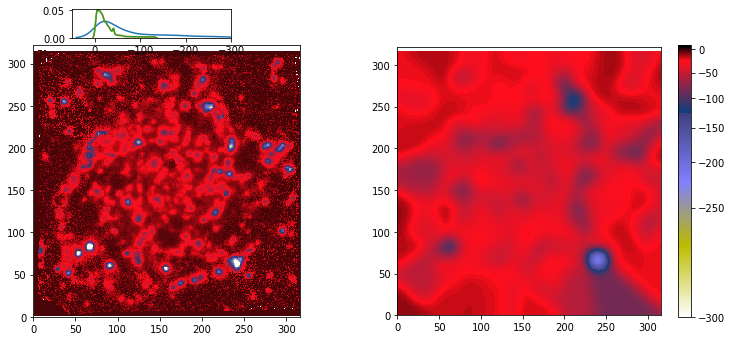

In [120]:
EW_Ha_HII_MUSE,image_HII_WHa,diff_WHa_fin=HIIextraction(F_WHa_MUSE,blobs_final,kind=1,we=2)

diff_WHa=create_diff(F_WHa_MUSE,blobs_final,FWHM_MUSE)

(nx,ny) = F_WHa_MUSE.shape
fig, axes = plt.subplots(1,2, figsize=(13,5))
cmap='gist_stern_r'
im_Ha_MUSE=axes[0].imshow(F_WHa_MUSE, interpolation='none',\
                                     cmap=cmap, label=r'H$\alpha$',\
                              norm=colors.PowerNorm(gamma=0.5),vmin=-300,vmax=10) 
clim=im_Ha_MUSE.properties()['clim']
im_WHa_MUSE=axes[1].imshow(diff_WHa, interpolation='none',\
                                     cmap=cmap, label=r'H$\alpha$', clim=clim) 

fig.colorbar(im_Ha_MUSE)

axes[0].set_xlim(0,nx)
axes[0].set_ylim(0,ny)
axes[1].set_xlim(0,nx)
axes[1].set_ylim(0,ny)

ax_hist_MUSE = fig.add_axes([0.2, 0.9, 0.17, 0.08]) 
sns.distplot(EW_Ha_HII_MUSE, ax=ax_hist_MUSE, hist=False)
sns.distplot(diff_WHa, ax=ax_hist_MUSE, hist=False)
sns.distplot(diff_WHa_fin, ax=ax_hist_MUSE, hist=False)
ax_hist_MUSE.set_xlim(50,-300)
#ax_hist_MUSE.set_yscale('function', functions=forward)
ax_hist_MUSE.set_yscale('function', functions=(forward, inverse))
#ax_hist_MUSE=sns.distplot(EW_Ha_HII_MUSE, ax=axes[1][0], hist=False)
#sns.distplot(diff_WHa, ax=ax_hist_MUSE, hist=False)


#ax_hist_MUSE.set_xlim(50,-300)
#ax_hist_MUSE.set_yscale('function', functions=(forward, inverse))
mean_EW_Ha_HII_MUSE_clean = np.nanmean(EW_Ha_HII_MUSE)
std_EW_Ha_HII_MUSE_clean = np.nanstd(EW_Ha_HII_MUSE)
print("# HII EW clean= ",mean_EW_Ha_HII_MUSE_clean,std_EW_Ha_HII_MUSE_clean)
mean_EW_diff = np.nanmean(diff_WHa)
std_EW_diff = np.nanstd(diff_WHa)
print("# EW diff= ",mean_EW_diff,std_EW_diff)



# HII EW clean=  -41.21701239184413 50.187828737983416
# EW diff=  -15.000803352375026 11.632899459967655


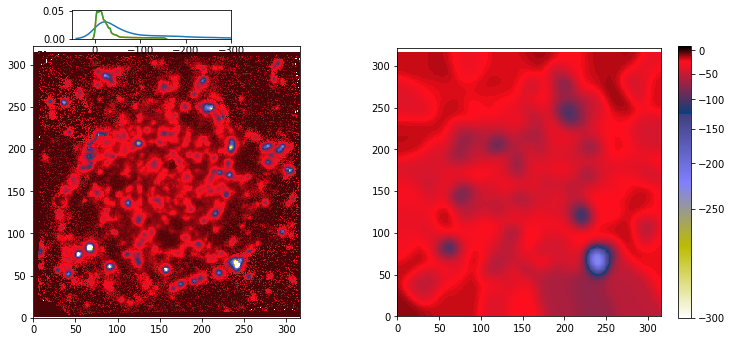

In [83]:
EW_Ha_HII_MUSE,image_HII_WHa,diff_WHa_fin=HIIextraction(F_WHa_MUSE,blobs_final,kind=1,we=2)

diff_WHa=create_diff(F_WHa_MUSE,blobs_final,FWHM_MUSE)

(nx,ny) = F_WHa_MUSE.shape
fig, axes = plt.subplots(1,2, figsize=(13,5))
cmap='gist_stern_r'
im_Ha_MUSE=axes[0].imshow(F_WHa_MUSE, interpolation='none',\
                                     cmap=cmap, label=r'H$\alpha$',\
                              norm=colors.PowerNorm(gamma=0.5),vmin=-300,vmax=10) 
clim=im_Ha_MUSE.properties()['clim']
im_WHa_MUSE=axes[1].imshow(diff_WHa, interpolation='none',\
                                     cmap=cmap, label=r'H$\alpha$', clim=clim) 

fig.colorbar(im_Ha_MUSE)

axes[0].set_xlim(0,nx)
axes[0].set_ylim(0,ny)
axes[1].set_xlim(0,nx)
axes[1].set_ylim(0,ny)

ax_hist_MUSE = fig.add_axes([0.2, 0.9, 0.17, 0.08]) 
sns.distplot(EW_Ha_HII_MUSE, ax=ax_hist_MUSE, hist=False)
sns.distplot(diff_WHa, ax=ax_hist_MUSE, hist=False)
sns.distplot(diff_WHa_fin, ax=ax_hist_MUSE, hist=False)
ax_hist_MUSE.set_xlim(50,-300)
#ax_hist_MUSE.set_yscale('function', functions=forward)
ax_hist_MUSE.set_yscale('function', functions=(forward, inverse))
#ax_hist_MUSE=sns.distplot(EW_Ha_HII_MUSE, ax=axes[1][0], hist=False)
#sns.distplot(diff_WHa, ax=ax_hist_MUSE, hist=False)


#ax_hist_MUSE.set_xlim(50,-300)
#ax_hist_MUSE.set_yscale('function', functions=(forward, inverse))
mean_EW_Ha_HII_MUSE_clean = np.nanmean(EW_Ha_HII_MUSE)
std_EW_Ha_HII_MUSE_clean = np.nanstd(EW_Ha_HII_MUSE)
print("# HII EW clean= ",mean_EW_Ha_HII_MUSE_clean,std_EW_Ha_HII_MUSE_clean)
mean_EW_diff = np.nanmean(diff_WHa)
std_EW_diff = np.nanstd(diff_WHa)
print("# EW diff= ",mean_EW_diff,std_EW_diff)



1sig Ha-map =  0.005261778305456912 ; 1sig MUSE-V  0.0023228462231932503
# HII reg. Initial =  1784
# HII reg. 2nd =  1515
# HII reg. additional =  1055
# X_sqr =  108.83970143460904
# HII reg clean= 2167


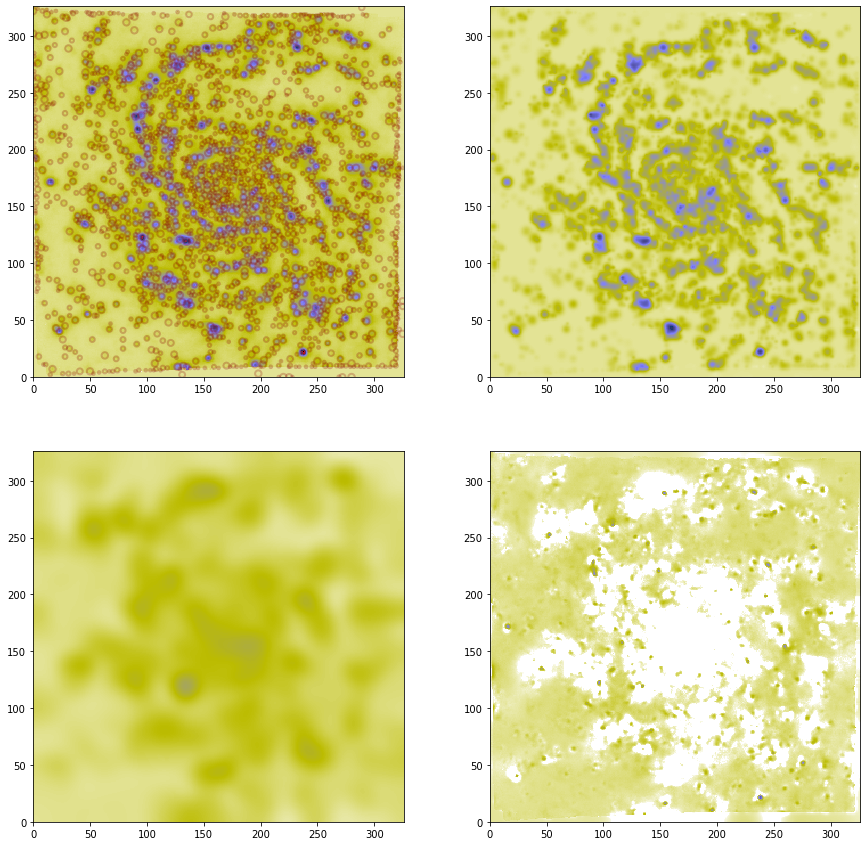

In [92]:
#    tri_MUSE = Delaunay(points_MUSE)
#    diff_p_MUSE = np.zeros((len(tri_MUSE.simplices),2))


##################################################################
# Running the script!
#name="NGC6975"
#name="NGC2906"
name="NGC4030"
file="MUSE/flux_elines."+name+".cube.fits.gz"
#file="MUSE/flux_elines.NGC4030.cube.fits.gz"
hdu=fits.open(file)
data=hdu[0].data
hdr=hdu[0].header
F_Ha_MUSE=data[20,:,:]
eF_Ha_MUSE=data[140,:,:]
F_WHa_MUSE=data[110,:,:]
file_SSP="MUSE/"+name+".SSP.cube.fits.gz"
hdu=fits.open(file_SSP)
data=hdu[0].data
hdr=hdu[0].header
V_MUSE=data[0,:,:]
V_MUSE[V_MUSE==-1.0]=0.0

blobs_final,blobs_F_Ha,image_HII,diff_map_final=HIIblob(F_Ha_MUSE,V_MUSE,FWHM_MUSE, MUSE_1sig=0, MUSE_1sig_V=0, plot=1)


In [85]:
EW_Ha_HII_MUSE,image_HII_WHa,diff_WHa_fin=HIIextraction(F_WHa_MUSE,blobs_final,kind=1,we=2)

diff_WHa=create_diff(F_WHa_MUSE,blobs_final,FWHM_MUSE)

(nx,ny) = F_WHa_MUSE.shape
fig, axes = plt.subplots(1,2, figsize=(13,5))
cmap='gist_stern_r'
im_Ha_MUSE=axes[0].imshow(F_WHa_MUSE, interpolation='none',\
                                     cmap=cmap, label=r'H$\alpha$',\
                              norm=colors.PowerNorm(gamma=0.5),vmin=-300,vmax=10) 
clim=im_Ha_MUSE.properties()['clim']
im_WHa_MUSE=axes[1].imshow(diff_WHa, interpolation='none',\
                                     cmap=cmap, label=r'H$\alpha$',\
                           norm=colors.PowerNorm(gamma=0.5),clim=clim) 

fig.colorbar(im_Ha_MUSE)

axes[0].set_xlim(0,nx)
axes[0].set_ylim(0,ny)
axes[1].set_xlim(0,nx)
axes[1].set_ylim(0,ny)

ax_hist_MUSE = fig.add_axes([0.2, 0.9, 0.17, 0.08]) 
sns.distplot(EW_Ha_HII_MUSE, ax=ax_hist_MUSE, hist=False)
sns.distplot(diff_WHa, ax=ax_hist_MUSE, hist=False)
sns.distplot(diff_WHa_fin, ax=ax_hist_MUSE, hist=False)
ax_hist_MUSE.set_xlim(50,-300)
#ax_hist_MUSE.set_yscale('function', functions=forward)
ax_hist_MUSE.set_yscale('function', functions=(forward, inverse))
#ax_hist_MUSE=sns.distplot(EW_Ha_HII_MUSE, ax=axes[1][0], hist=False)
#sns.distplot(diff_WHa, ax=ax_hist_MUSE, hist=False)


#ax_hist_MUSE.set_xlim(50,-300)
#ax_hist_MUSE.set_yscale('function', functions=(forward, inverse))
mean_EW_Ha_HII_MUSE_clean = np.nanmean(EW_Ha_HII_MUSE)
std_EW_Ha_HII_MUSE_clean = np.nanstd(EW_Ha_HII_MUSE)
print("# HII EW clean= ",mean_EW_Ha_HII_MUSE_clean,std_EW_Ha_HII_MUSE_clean)
mean_EW_diff = np.nanmean(diff_WHa)
std_EW_diff = np.nanstd(diff_WHa)
print("# EW diff= ",mean_EW_diff,std_EW_diff)



# HII EW clean=  -27.822505298709082 26.442161643386303
# EW diff=  -17.22949951000462 8.157581827100346


1sig Ha-map =  0.006100135671765995 ; 1sig MUSE-V  0.0031275233486667275
# HII reg. Initial =  951
# HII reg. 2nd =  571
# HII reg. additional =  248
# X_sqr =  20.864561987489225
# HII reg clean= 710


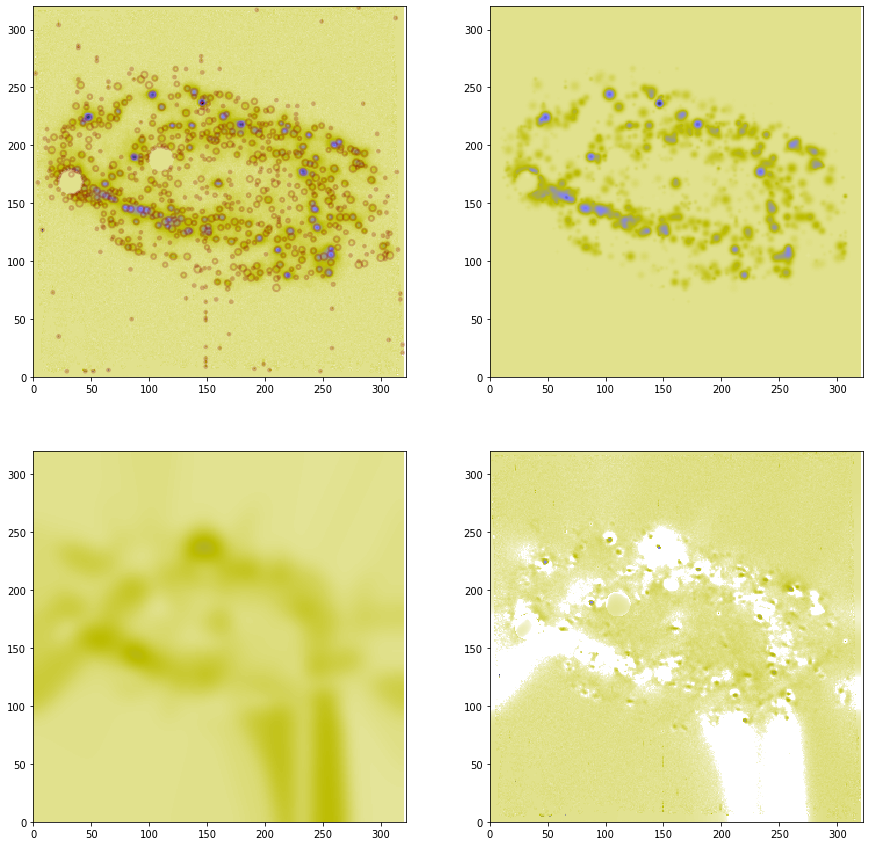

In [86]:
#    tri_MUSE = Delaunay(points_MUSE)
#    diff_p_MUSE = np.zeros((len(tri_MUSE.simplices),2))


##################################################################
# Running the script!
#name="NGC6975"
name="NGC2906"
#name="NGC4030"
file="MUSE/flux_elines."+name+".cube.fits.gz"
#file="MUSE/flux_elines.NGC4030.cube.fits.gz"
hdu=fits.open(file)
data=hdu[0].data
hdr=hdu[0].header
F_Ha_MUSE=data[20,:,:]
eF_Ha_MUSE=data[140,:,:]
F_WHa_MUSE=data[110,:,:]
file_SSP="MUSE/"+name+".SSP.cube.fits.gz"
hdu=fits.open(file_SSP)
data=hdu[0].data
hdr=hdu[0].header
V_MUSE=data[0,:,:]
V_MUSE[V_MUSE==-1.0]=0.0

blobs_final,blobs_F_Ha,image_HII,diff_map_final=HIIblob(F_Ha_MUSE,V_MUSE,FWHM_MUSE, MUSE_1sig=0, MUSE_1sig_V=0, plot=1)


# HII EW clean=  -34.008067607489494 59.98554383809895
# EW diff=  -6.7673423754808155 6.6741862349940355


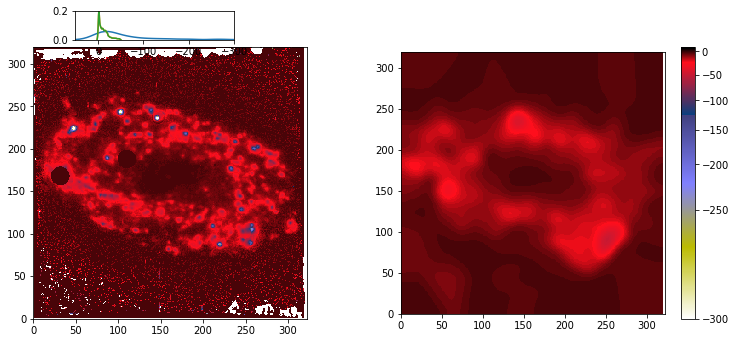

In [87]:
EW_Ha_HII_MUSE,image_HII_WHa,diff_WHa_fin=HIIextraction(F_WHa_MUSE,blobs_final,kind=1,we=2)

diff_WHa=create_diff(F_WHa_MUSE,blobs_final,FWHM_MUSE)

(nx,ny) = F_WHa_MUSE.shape
fig, axes = plt.subplots(1,2, figsize=(13,5))
cmap='gist_stern_r'
im_Ha_MUSE=axes[0].imshow(F_WHa_MUSE, interpolation='none',\
                                     cmap=cmap, label=r'H$\alpha$',\
                              norm=colors.PowerNorm(gamma=0.5),vmin=-300,vmax=10) 
clim=im_Ha_MUSE.properties()['clim']
im_WHa_MUSE=axes[1].imshow(diff_WHa, interpolation='none',\
                                     cmap=cmap, label=r'H$\alpha$',\
                           norm=colors.PowerNorm(gamma=0.5),clim=clim) 

fig.colorbar(im_Ha_MUSE)

axes[0].set_xlim(0,nx)
axes[0].set_ylim(0,ny)
axes[1].set_xlim(0,nx)
axes[1].set_ylim(0,ny)

ax_hist_MUSE = fig.add_axes([0.2, 0.9, 0.17, 0.08]) 
sns.distplot(EW_Ha_HII_MUSE, ax=ax_hist_MUSE, hist=False)
sns.distplot(diff_WHa, ax=ax_hist_MUSE, hist=False)
sns.distplot(diff_WHa_fin, ax=ax_hist_MUSE, hist=False)
ax_hist_MUSE.set_xlim(50,-300)
#ax_hist_MUSE.set_yscale('function', functions=forward)
ax_hist_MUSE.set_yscale('function', functions=(forward, inverse))
#ax_hist_MUSE=sns.distplot(EW_Ha_HII_MUSE, ax=axes[1][0], hist=False)
#sns.distplot(diff_WHa, ax=ax_hist_MUSE, hist=False)


#ax_hist_MUSE.set_xlim(50,-300)
#ax_hist_MUSE.set_yscale('function', functions=(forward, inverse))
mean_EW_Ha_HII_MUSE_clean = np.nanmean(EW_Ha_HII_MUSE)
std_EW_Ha_HII_MUSE_clean = np.nanstd(EW_Ha_HII_MUSE)
print("# HII EW clean= ",mean_EW_Ha_HII_MUSE_clean,std_EW_Ha_HII_MUSE_clean)
mean_EW_diff = np.nanmean(diff_WHa)
std_EW_diff = np.nanstd(diff_WHa)
print("# EW diff= ",mean_EW_diff,std_EW_diff)



1sig Ha-map =  0.03259411442675947 ; 1sig MUSE-V  nan
# HII reg. Initial =  73
# HII reg. 2nd =  75
# HII reg. additional =  78
# X_sqr =  246.61286533248295
# HII reg clean= 131


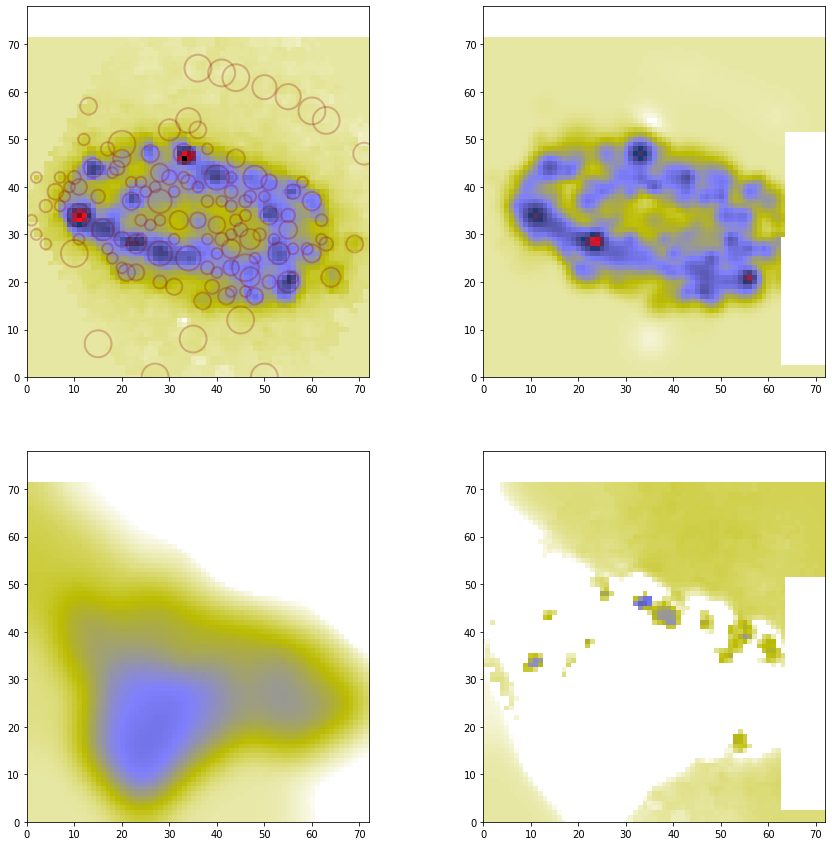

In [78]:
blobs_final_CAL,blobs_F_Ha_CAL,image_HII_CAL,diff_map_final_CAL=HIIblob(F_Ha_CAL,V_CAL,FWHM_CAL, MUSE_1sig=0, MUSE_1sig_V=0, plot=1)

In [603]:
EW_Ha_HII_CAL,image_HII_WHa,diff_WHa_fin=HIIextraction(F_Ha_CAL,blobs_final,kind=1,we=2)

diff_WHa=create_diff(F_Ha_CAL,blobs_final,FWHM_CAL)

(nx,ny) = F_WHa_CAL.shape
fig, axes = plt.subplots(2,2, figsize=(15,15))
cmap='gist_stern_r'
im_Ha_CAL=axes[0][0].imshow(F_WHa_CAL, interpolation='none',\
                                     cmap=cmap, label=r'H$\alpha$',vmin=-300,vmax=10) 
clim=im_Ha_CAL.properties()['clim']
im_WHa_CAL=axes[0][1].imshow(diff_WHa, interpolation='none',\
                                     cmap=cmap, label=r'H$\alpha$', clim=clim) 
axes[0][0].set_xlim(0,nx)
axes[0][0].set_ylim(0,ny)
axes[0][1].set_xlim(0,nx)
axes[0][1].set_ylim(0,ny)

ax_hist_CAL=sns.distplot(EW_Ha_HII_CAL, ax=axes[1][0], hist=False)
sns.distplot(diff_WHa, ax=ax_hist_CAL, hist=False)

ax_hist_CAL.set_xlim(50,-300)
ax_hist_CAL.set_yscale('function', functions=(forward, inverse))
mean_EW_Ha_HII_CAL_clean = np.nanmean(EW_Ha_HII_CAL)
std_EW_Ha_HII_CAL_clean = np.nanstd(EW_Ha_HII_CAL)
print("# HII EW clean= ",mean_EW_Ha_HII_CAL_clean,std_EW_Ha_HII_CAL_clean)
mean_EW_diff = np.nanmean(diff_WHa)
std_EW_diff = np.nanstd(diff_WHa)
print("# EW diff= ",mean_EW_diff,std_EW_diff)



NameError: name 'F_WHa_CAL' is not defined

# DIMENSIONS =  316 322
# 1sig MUSE-V 0.002 |  0.0001614589775037943
# PSF FWHM = 5.0
# HIIreg MUSE= 1222
# HII reg clean= 1160
# Radius =  1.8082015457788352 1.4000000000000001 3.5 0.7531712912373
# =  1160 2299
# Diff before =  884
# Diff after =  456
# DIFF EW =  -12.42046991721056 12.958436607144684
# HII EW =  -33.22449285419032 47.36370753893406
# HIIreg MUSE clean= 588
# Radius_clean =  1.8625712674871422 1.1313708498984762 2.8284271247461903 0.7509153592076764
# Hii Flux Ha= [122.74764415  95.58223821  98.28564158  77.08834117  86.43891128
  69.96386092 115.87614047  74.03106503  94.96759714  87.00211248
  91.57084573  46.8114919   67.54107674  83.33871557  76.34415269
  36.92265926  35.0069965   48.42370416  40.04401687  31.92117643]
# Hii Flux Ha= [126.69834121  98.66763226 100.69364117  80.46855897  89.64327783
  72.84187311 117.34287978  75.86557452  95.43093049  88.35677353
  93.51179988  49.23371457  68.47498114  84.87902886  77.06699132
  38.46159332  36.5725445   49.753

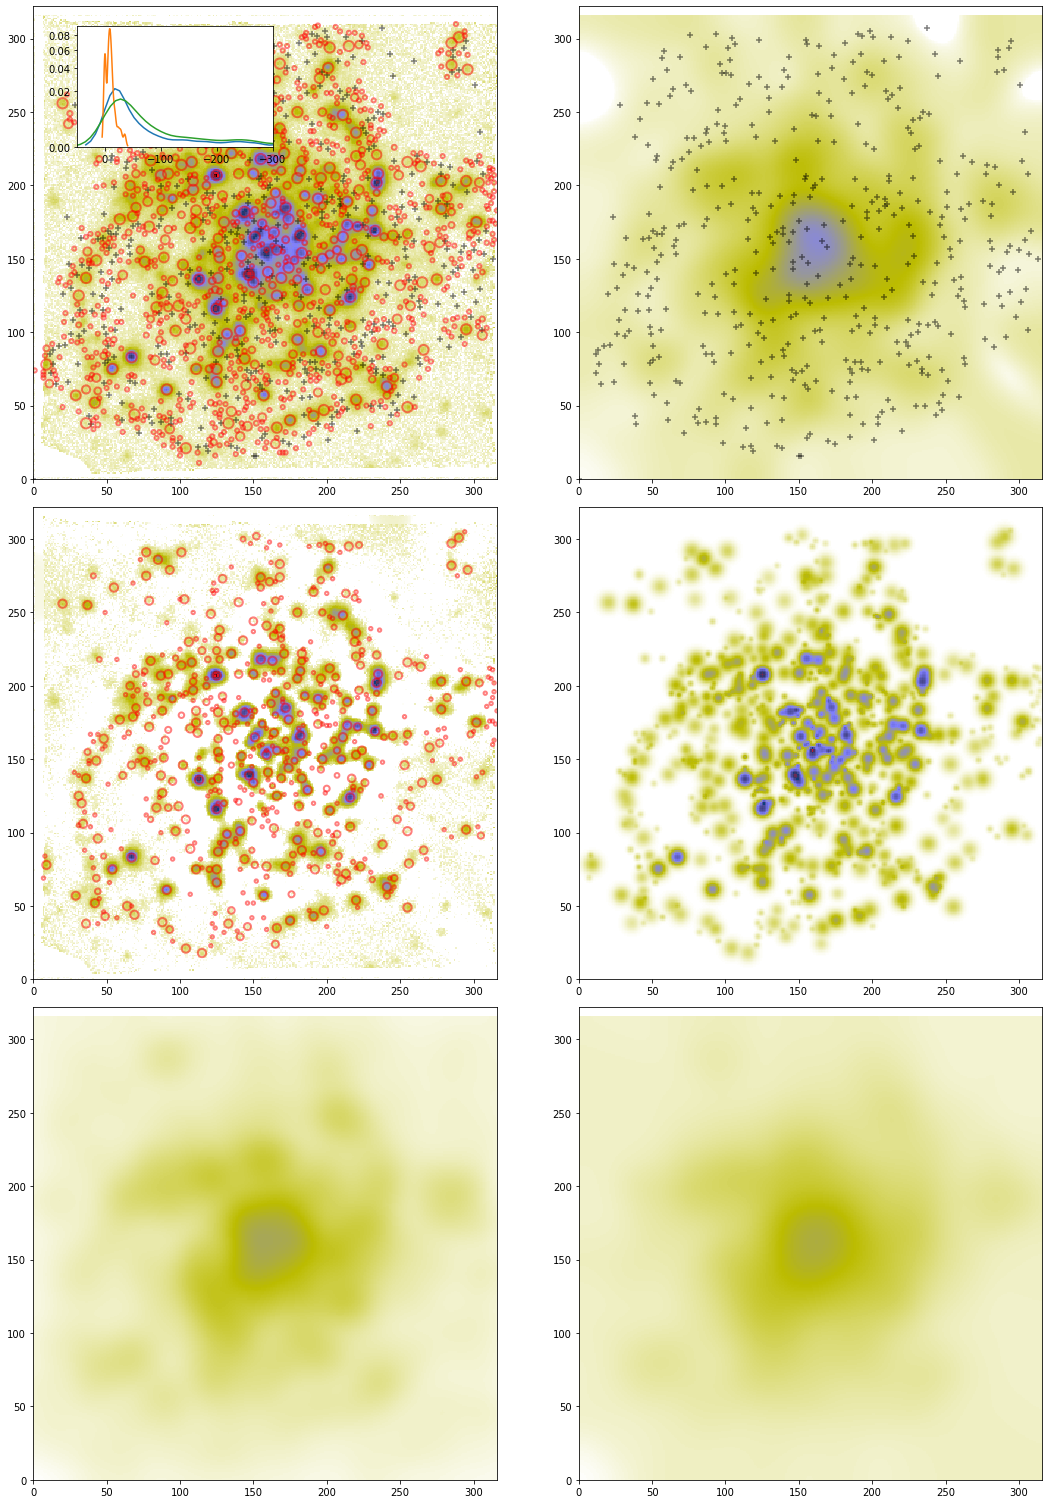

In [421]:
#
# Treat NaNs!!!!
#
F_Ha_MUSE = np.ma.masked_invalid(F_Ha_MUSE)
V_MUSE = np.ma.masked_invalid(V_MUSE)
#print(V_MUSE)
(nx,ny)=F_Ha_MUSE.shape
print("# DIMENSIONS = ",nx,ny)
#F_Ha_MUSE_g=gaussian_filter(F_Ha_MUSE, sigma=20*FWHM_MUSE)
F_Ha_MUSE_g=gaussian_filter(F_Ha_MUSE, sigma=2*FWHM_MUSE)
V_MUSE_g=gaussian_filter(V_MUSE, sigma=2*FWHM_MUSE)
#mask_MUSE = (F_Ha_MUSE_g<2*MUSE_1sig) | (V_MUSE_g<0.002) 
print('# 1sig MUSE-V 0.002 | ',MUSE_1sig_V)
mask_MUSE = (F_Ha_MUSE_g<2*MUSE_1sig) | (V_MUSE_g<0.5*MUSE_1sig_V) 
#mask_MUSE = 
F_Ha_MUSE_masked = np.ma.array(F_Ha_MUSE, mask = mask_MUSE, fill_value=0.0)
F_Ha_MUSE_fill = F_Ha_MUSE_masked.filled()

F_Ha_CAL_g=gaussian_filter(F_Ha_CAL, sigma=20*FWHM_CAL)
V_CAL_g=gaussian_filter(V_CAL, sigma=2)
mask_CAL = (F_Ha_CAL_g<2*CAL_1sig) | (V_CAL<0.025)
F_Ha_CAL_masked = np.ma.array(F_Ha_CAL, mask = mask_CAL, fill_value=0.0)
F_Ha_CAL_fill = F_Ha_CAL_masked.filled()


#print(F_Ha_MUSE_masked)

fig, axes = plt.subplots(3,2, figsize=(16,21))
#fig, axes[0][0] = plt.subplots(1,2, figsize=(12,6))

cmap='gist_stern_r'
im_Ha_MUSE=axes[0][0].imshow(np.sqrt(F_Ha_MUSE), interpolation='none',\
               cmap=cmap, label=r'H$\alpha$') 



print("# PSF FWHM =",FWHM_MUSE)
blobs_log_MUSE = blob_log(F_Ha_MUSE_fill, min_sigma=0.8,\
                          max_sigma=2.0,\
                          num_sigma=30, threshold=1.5*MUSE_1sig)

blobs_log_MUSE[:, 2] = blobs_log_MUSE[:, 2] * 1.75 #sqrt(2) #1.75 #sqrt(2)
print('# HIIreg MUSE=',len(blobs_log_MUSE))
EW_Ha_HII_MUSE = np.zeros(len(blobs_log_MUSE)) 
EW_Ha_HII_MUSE_clean = np.zeros(len(blobs_log_MUSE)) 
diff_p_MUSE = np.zeros((len(blobs_log_MUSE),2))
i=0
points_MUSE = blobs_log_MUSE[:,0:2]
radius_HII=blobs_log_MUSE[:,2]
#
# Look for the 2nd more near point
#
dist_HII_self,index_HII_self = do_kdtree(points_MUSE,points_MUSE,k=2)
dist_HII_self = dist_HII_self[:,1]
index_HII_self = index_HII_self[:,1]
#
# Mask regions that are inside another!
#
mask_HII_self = (dist_HII_self>radius_HII) 
blobs_log_MUSE = blobs_log_MUSE[mask_HII_self]
print('# HII reg clean=',len(blobs_log_MUSE))
points_MUSE = blobs_log_MUSE[:,0:2]
radius_HII=blobs_log_MUSE[:,2]
print("# Radius = ",np.mean(radius_HII),np.min(radius_HII),np.max(radius_HII),np.std(radius_HII))


for blob in blobs_log_MUSE:
        y, x, r = blob
        c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False, alpha=0.5)
        val = F_Ha_MUSE_masked[np.int(y),np.int(x)]
        val_g = F_Ha_MUSE_g[np.int(y),np.int(x)]
        ix = int(round(x))
        iy = int(round(y))
        EW_Ha_HII_MUSE[i]=F_WHa_MUSE[iy,ix]
        axes[0][0].add_patch(c)
#        axes[1][0].add_patch(c)
#        print('dist=',dist_HII_self[i])
        i=i+1
#
# Diffuse points
#
#points_MUSE = blobs_log_MUSE[:,0:2]
tri_MUSE = Delaunay(points_MUSE)
diff_p_MUSE = np.zeros((len(tri_MUSE.simplices),2))


print ("# = ",len(blobs_log_MUSE),len(tri_MUSE.simplices))
#diff_p_MUSE = np.zeros((len(blobs_log_MUSE),2))
i=0
for j, s in enumerate(tri_MUSE.simplices):
    p = points_MUSE[s].mean(axis=0)
    diff_p_MUSE[s,0]=p[0]
    diff_p_MUSE[s,1]=p[1]

diff_p_MUSE = unique2d(diff_p_MUSE)

#######
# Clean points inside others
#combined_x_y_arrays = numpy.dstack([y_array.ravel(),x_array.ravel()])[0]
#points_list = list(points_MUSE.transpose())

dist_HII_diff,index_HII_diff = do_kdtree(points_MUSE,diff_p_MUSE)
print("# Diff before = ",len(diff_p_MUSE))
mask_HII_diff = dist_HII_diff>2*blobs_log_MUSE[index_HII_diff,2]
diff_p_MUSE = diff_p_MUSE[mask_HII_diff]
print("# Diff after = ",len(diff_p_MUSE))
EW_Ha_diff_MUSE = np.zeros((len(diff_p_MUSE)))
F_Ha_diff_MUSE = np.zeros((len(diff_p_MUSE)))
for i,val in enumerate(diff_p_MUSE):
    ix = int(round(val[0]))
    iy = int(round(val[1]))
    EW_Ha_diff_MUSE[i]=F_WHa_MUSE[ix,iy]
    F_Ha_diff_MUSE[i]=F_Ha_MUSE[ix,iy]
#EW_Ha_diff_MUSE = np.unique(EW_Ha_diff_MUSE)
mean_EW_Ha_diff_MUSE = np.nanmean(EW_Ha_diff_MUSE)
std_EW_Ha_diff_MUSE = np.nanstd(EW_Ha_diff_MUSE)
print("# DIFF EW = ",mean_EW_Ha_diff_MUSE,std_EW_Ha_diff_MUSE)
mean_EW_Ha_HII_MUSE = np.nanmean(EW_Ha_HII_MUSE)
std_EW_Ha_HII_MUSE = np.nanstd(EW_Ha_HII_MUSE)
print("# HII EW = ",mean_EW_Ha_HII_MUSE,std_EW_Ha_HII_MUSE)


#print ("# = ",len(diff_p_MUSE),len(EW_Ha_diff_MUSE))
#diff_p_MUSE = np.unique(diff_p_MUSE)
axes[0][0].scatter(diff_p_MUSE[:,1],diff_p_MUSE[:,0],marker='+',color='black', alpha=0.5)


######################
#
xgrid=np.arange(0, ny, 1)
ygrid=np.arange(0, nx, 1)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
#print("# Shape = ",Xgrid.shape,Ygrid.shape,nx,ny)
#new_array=np.concatenate((diff_p_MUSE[:,1],diff_p_MUSE[:,0]),axis=0)
new_array=np.array((diff_p_MUSE[:,1],diff_p_MUSE[:,0])).T
#print(new_array.shape,diff_p_MUSE.shape)
#print(F_Ha_diff_MUSE,Xgrid)
#diff_interp_map = griddata(diff_p_MUSE, F_Ha_diff_MUSE, (Xgrid.T, Ygrid.T), method='cubic')
diff_interp_map = griddata(new_array, F_Ha_diff_MUSE, (Xgrid, Ygrid), method='nearest')
clim=im_Ha_MUSE.properties()['clim']
#axes[1].imshow(my_image2, clim=clim)
diff_interp_map_g=gaussian_filter(diff_interp_map, sigma=2*FWHM_MUSE)
axes[0][1].imshow(np.sqrt(diff_interp_map_g), interpolation='none',\
               cmap=cmap, clim=clim) 
axes[0][1].scatter(diff_p_MUSE[:,1],diff_p_MUSE[:,0],marker='+',\
                   color='black', alpha=0.5, clim=clim)



#
# Diffuse clean map
#
F_Ha_MUSE_clean = F_Ha_MUSE - diff_interp_map_g
axes[1][0].imshow(np.sqrt(F_Ha_MUSE_clean), interpolation='none',\
               cmap=cmap, clim=clim) 
#
# We detect the blobs again!
#
F_Ha_MUSE_clean_masked = np.ma.array(F_Ha_MUSE_clean, mask = mask_MUSE, fill_value=0.0)
F_Ha_MUSE_fill_clean = F_Ha_MUSE_clean_masked.filled()
blobs_log_MUSE_clean = blob_log(F_Ha_MUSE_fill_clean, min_sigma=0.8,\
                          max_sigma=2,\
                          num_sigma=30, threshold=2*MUSE_1sig,\
                               overlap=0.5,log_scale=True, exclude_border=np.int(FWHM_MUSE))

blobs_log_MUSE_clean[:, 2] = blobs_log_MUSE_clean[:, 2] * sqrt(2) #1.75 #sqrt(2)
print('# HIIreg MUSE clean=',len(blobs_log_MUSE_clean))
EW_Ha_HII_MUSE_clean = np.zeros(len(blobs_log_MUSE_clean)) 
points_MUSE_clean = blobs_log_MUSE_clean[:,0:2]
radius_HII_clean=blobs_log_MUSE_clean[:,2]
#
# Look for the 2nd more near point
#
dist_HII_self,index_HII_self = do_kdtree(points_MUSE_clean,points_MUSE_clean,k=2)
dist_HII_self = dist_HII_self[:,1]
index_HII_self = index_HII_self[:,1]
#
# Mask regions that are inside another!
#
mask_HII_self = (dist_HII_self>radius_HII_clean) 
blobs_log_MUSE_clean = blobs_log_MUSE_clean[mask_HII_self]
points_MUSE_clean = blobs_log_MUSE_clean[:,0:2]
radius_HII_clean=blobs_log_MUSE_clean[:,2]
print("# Radius_clean = ",np.mean(radius_HII_clean),np.min(radius_HII_clean),\
      np.max(radius_HII_clean),np.std(radius_HII_clean))
i=0
for blob in blobs_log_MUSE_clean:
        y, x, r = blob
        c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False, alpha=0.5)
        val = F_Ha_MUSE_masked[np.int(y),np.int(x)]
        val_g = F_Ha_MUSE_g[np.int(y),np.int(x)]
        ix = int(round(x))
        iy = int(round(y))
        EW_Ha_HII_MUSE_clean[i]=F_WHa_MUSE[iy,ix]
        axes[1][0].add_patch(c)
        i=i+1
        
blobs_F_Ha_org=extract_flux(blobs_log_MUSE_clean,F_Ha_MUSE,kind=0,we=0)
print('# Hii Flux Ha=',blobs_F_Ha_org[0:20])
blobs_F_Ha=extract_flux(blobs_log_MUSE_clean,F_Ha_MUSE,kind=0,we=2)
print('# Hii Flux Ha=',blobs_F_Ha[0:20])
blobs_WHa=extract_flux(blobs_log_MUSE_clean,F_WHa_MUSE,kind=1,we=1)
print('# Hii WHa=',blobs_WHa[0:20])

image_HII=create_HII_image(blobs_log_MUSE_clean,blobs_F_Ha,ny,nx)
#image_HII
#clim=im.properties()['clim']
#axes[1].imshow(my_image2, clim=clim)
#clim=im_Ha_MUSE.properties()['clim']
im_HII=axes[1][1].imshow(np.sqrt(image_HII), interpolation='none',\
               cmap=cmap, label=r'Hii regions', clim=clim) 

image_clean_HII = F_Ha_MUSE-image_HII

#im_clean_HII=axes[2][0].imshow(np.sqrt(image_clean_HII), interpolation='none',\
#               cmap=cmap, label=r'res Hii regions', clim=clim) 
image_clean_HII_g=gaussian_filter(image_clean_HII, sigma=2*FWHM_MUSE)
im_clean_HII_g=axes[2][0].imshow(np.sqrt(image_clean_HII_g), interpolation='none',\
               cmap=cmap, label=r'res Hii regions g', clim=clim) 



#
# Recalculating the Diffuse
#
for i,val in enumerate(diff_p_MUSE):
    ix = int(round(val[0]))
    iy = int(round(val[1]))
    EW_Ha_diff_MUSE[i]=F_WHa_MUSE[ix,iy]*image_clean_HII_g[ix,iy]/F_Ha_diff_MUSE[i]
    F_Ha_diff_MUSE[i]=image_clean_HII_g[ix,iy]

mean_EW_Ha_diff_MUSE = np.nanmean(EW_Ha_diff_MUSE)
std_EW_Ha_diff_MUSE = np.nanstd(EW_Ha_diff_MUSE)
print("# DIFF EW = ",mean_EW_Ha_diff_MUSE,std_EW_Ha_diff_MUSE)

diff_interp_map = griddata(new_array, F_Ha_diff_MUSE, (Xgrid, Ygrid), method='nearest')
diff_interp_map_g=gaussian_filter(diff_interp_map, sigma=2*FWHM_MUSE)
im_clean_HII_g=axes[2][1].imshow(np.sqrt(diff_interp_map_g), interpolation='none',\
               cmap=cmap, label=r'diff', clim=clim) 
#i=0
#for blob in blobs_log_MUSE:
#        y, x, r = blob
#        c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False, alpha=0.5)
#        axes[1][0].add_patch(c)
#        ix = int(round(x))
#        iy = int(round(y))
#        EW_Ha_HII_MUSE_clean[i]=(F_Ha_MUSE_clean[iy,ix]/F_Ha_MUSE[iy,ix])*F_WHa_MUSE[iy,ix]
#        i=i+1

axes[0][0].set_xlim(0,nx)
axes[0][0].set_ylim(0,ny)
axes[0][1].set_xlim(0,nx)
axes[0][1].set_ylim(0,ny)
axes[1][0].set_xlim(0,nx)
axes[1][0].set_ylim(0,ny)
axes[1][1].set_xlim(0,nx)
axes[1][1].set_ylim(0,ny)
axes[2][0].set_xlim(0,nx)
axes[2][0].set_ylim(0,ny)
axes[2][1].set_xlim(0,nx)
axes[2][1].set_ylim(0,ny)

# EW(Ha) hist

#ax_hist_MUSE.set_yscale('log')
ax_hist_MUSE = fig.add_axes([0.1, 0.9, 0.17, 0.08]) 
sns.distplot(EW_Ha_HII_MUSE, ax=ax_hist_MUSE, hist=False)
sns.distplot(EW_Ha_diff_MUSE, ax=ax_hist_MUSE, hist=False)
sns.distplot(EW_Ha_HII_MUSE_clean, ax=ax_hist_MUSE, hist=False)
ax_hist_MUSE.set_xlim(50,-300)
ax_hist_MUSE.set_yscale('function', functions=(forward, inverse))
mean_EW_Ha_HII_MUSE_clean = np.nanmean(EW_Ha_HII_MUSE_clean)
std_EW_Ha_HII_MUSE_clean = np.nanstd(EW_Ha_HII_MUSE_clean)
print("# HII EW clean= ",mean_EW_Ha_HII_MUSE_clean,std_EW_Ha_HII_MUSE_clean)

             


plt.tight_layout()
plt.show()

In [398]:
#print(blobs_F_Ha)
plt.scatter(blobs_F_Ha_org,blobs_F_Ha)
plt.xlim(0,500)
plt.ylim(0,500)
plt.axes().set_aspect('equal', adjustable='box')

0.7094975731610955


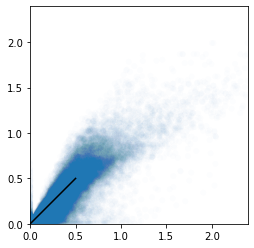

In [399]:
#print(blobs_F_Ha)
plt.scatter(F_Ha_MUSE,image_HII,alpha=0.01,edgecolor='none')
x_plot=np.linspace(0,0.5,100)
plt.plot(x_plot,x_plot,color='black')
max_val = np.max(np.concatenate((F_Ha_MUSE,image_HII)))
plt.xlim(0,0.5*max_val)
plt.ylim(0,0.5*max_val)
plt.axes().set_aspect('equal', adjustable='box')
rat=image_HII/F_Ha_MUSE
print(np.mean(rat[image_HII>0.05]))

In [12]:
F_Ha_MUSE_g=gaussian_filter(F_Ha_MUSE, sigma=20*FWHM_MUSE)
V_MUSE_g=gaussian_filter(V_MUSE, sigma=2*FWHM_MUSE)
mask_MUSE = (F_Ha_MUSE_g<2*MUSE_1sig) | (V_MUSE_g<0.002) 
F_Ha_MUSE_masked = np.ma.array(F_Ha_MUSE, mask = mask_MUSE, fill_value=0.0)
F_Ha_MUSE_fill = F_Ha_MUSE_masked.filled()

F_Ha_CAL_g=gaussian_filter(F_Ha_CAL, sigma=20*FWHM_CAL)
V_CAL_g=gaussian_filter(V_CAL, sigma=2)
mask_CAL = (F_Ha_CAL_g<2*CAL_1sig) | (V_CAL<0.025)
F_Ha_CAL_masked = np.ma.array(F_Ha_CAL, mask = mask_CAL, fill_value=0.0)
F_Ha_CAL_fill = F_Ha_CAL_masked.filled()


#print(F_Ha_MUSE_masked)

fig, axes = plt.subplots(2,1, figsize=(12,24))
#fig, axes = plt.subplots(1,2, figsize=(12,6))

cmap='gist_stern_r'
axes[0].imshow(np.sqrt(F_Ha_MUSE), interpolation='none',\
               cmap=cmap) 
               #vmin=-0.5*MUSE_1sig, vmax=300*MUSE_1sig)
axes[1].imshow(np.sqrt(F_Ha_CAL), interpolation='none',\
               cmap=cmap)
#, vmin=-0.5*CAL_1sig, vmax=300*CAL_1sig)
#axes[1].imshow(F_Ha_CAL, interpolation='none', cmap='viridis')

#blobs_log_MUSE = blob_log(F_Ha_MUSE_fill, min_sigma=1, max_sigma=3, num_sigma=100, threshold=.01)
print(FWHM_MUSE)
blobs_log_MUSE = blob_log(F_Ha_MUSE_fill, min_sigma=0.8,\
                          max_sigma=2.0,\
                          num_sigma=30, threshold=2*MUSE_1sig)
#blobs_log_MUSE = blob_log(F_Ha_MUSE_fill, min_sigma=1,\
#                          max_sigma=2.0,\
#                          num_sigma=3, threshold=1.5*MUSE_1sig)

blobs_log_MUSE[:, 2] = blobs_log_MUSE[:, 2] * 1.75 #sqrt(2)
print('# HIIreg MUSE=',len(blobs_log_MUSE))
EW_Ha_HII_MUSE = np.zeros((len(blobs_log_MUSE),2)) 
diff_p_MUSE = np.zeros((len(blobs_log_MUSE),2))
i=0
for blob in blobs_log_MUSE:
        y, x, r = blob
        c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False, alpha=0.5)
        val = F_Ha_MUSE_masked[np.int(y),np.int(x)]
        val_g = F_Ha_MUSE_g[np.int(y),np.int(x)]
        ix = int(round(x))
        iy = int(round(y))
        EW_Ha_HII_MUSE[i]=F_WHa_MUSE[iy,ix]
        axes[0].add_patch(c)
        i=i+1
#
# Diffuse points
#
points_MUSE = blobs_log_MUSE[:,0:2]
tri_MUSE = Delaunay(points_MUSE)
diff_p_MUSE = np.zeros((len(tri_MUSE.simplices),2))


print ("# = ",len(blobs_log_MUSE),len(tri_MUSE.simplices))
#diff_p_MUSE = np.zeros((len(blobs_log_MUSE),2))
i=0
for j, s in enumerate(tri_MUSE.simplices):
    p = points_MUSE[s].mean(axis=0)
    diff_p_MUSE[s,1]=p[0]
    diff_p_MUSE[s,0]=p[1]
#    ix = int(round(p[0]))
#    iy = int(round(p[1]))
#    EW_Ha_diff_MUSE[i]=F_WHa_MUSE[iy,ix]
#    i=i+1

diff_p_MUSE = unique2d(diff_p_MUSE)
EW_Ha_diff_MUSE = np.zeros((len(diff_p_MUSE)))
for i,val in enumerate(diff_p_MUSE):
    ix = int(round(val[0]))
    iy = int(round(val[1]))
    EW_Ha_diff_MUSE[i]=F_WHa_MUSE[iy,ix]
#EW_Ha_diff_MUSE = np.unique(EW_Ha_diff_MUSE)
mean_EW_Ha_diff_MUSE = np.nanmean(EW_Ha_diff_MUSE)
std_EW_Ha_diff_MUSE = np.nanstd(EW_Ha_diff_MUSE)
print("# DIFF EW = ",mean_EW_Ha_diff_MUSE,std_EW_Ha_diff_MUSE)
mean_EW_Ha_HII_MUSE = np.nanmean(EW_Ha_HII_MUSE)
std_EW_Ha_HII_MUSE = np.nanstd(EW_Ha_HII_MUSE)
print("# HII EW = ",mean_EW_Ha_HII_MUSE,std_EW_Ha_HII_MUSE)


#print ("# = ",len(diff_p_MUSE),len(EW_Ha_diff_MUSE))
#diff_p_MUSE = np.unique(diff_p_MUSE)
axes[0].scatter(diff_p_MUSE[:,0],diff_p_MUSE[:,1],marker='+',color='black', alpha=0.5)
# EW(Ha) hist
ax_hist_MUSE = fig.add_axes([0.1, 0.9, 0.17, 0.08]) 
sns.distplot(EW_Ha_HII_MUSE, ax=ax_hist_MUSE, hist=False)
sns.distplot(EW_Ha_diff_MUSE, ax=ax_hist_MUSE, hist=False)
ax_hist_MUSE.set_xlim(50,-300)
#ax_hist_MUSE.set_yscale('function', functions=forward)
ax_hist_MUSE.set_yscale('function', functions=(forward, inverse))
#ax_hist_MUSE.set_yscale('log')

blobs_log_CAL = blob_log(F_Ha_CAL_fill, min_sigma=0.8,\
                         max_sigma=2.0,\
                         num_sigma=30, threshold=1.5*CAL_1sig)
blobs_log_CAL[:, 2] = blobs_log_CAL[:, 2] * 1.75 # sqrt(2)
print('# HIIreg CAL=',len(blobs_log_CAL))
for blob in blobs_log_CAL:
        y, x, r = blob
        c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False, alpha=0.5)
        axes[1].add_patch(c)
#
# Diffuse points
#
points_CAL = blobs_log_CAL[:,0:2]
tri_CAL = Delaunay(points_CAL)
diff_p_CAL = np.zeros((len(tri_CAL.simplices),2))
for j, s in enumerate(tri_CAL.simplices):
    p = points_CAL[s].mean(axis=0)
    diff_p_CAL[s,1]=p[0]
    diff_p_CAL[s,0]=p[1]
diff_p_CAL = unique2d(diff_p_CAL)
axes[1].scatter(diff_p_CAL[:,0],diff_p_CAL[:,1],marker='+',color='black', alpha=0.5)
#axes.set_title(str(interp_method))

plt.tight_layout()
plt.show()

5.0
# HIIreg MUSE= 227
# =  227 417
# DIFF EW =  -19.26546778815391 12.89034566307502
# HII EW =  -29.498303618179875 28.446593335121886
# HIIreg CAL= 74


5.0
# HIIreg MUSE= 766
# =  766 1515
# =  586
# HIIreg CAL= 76


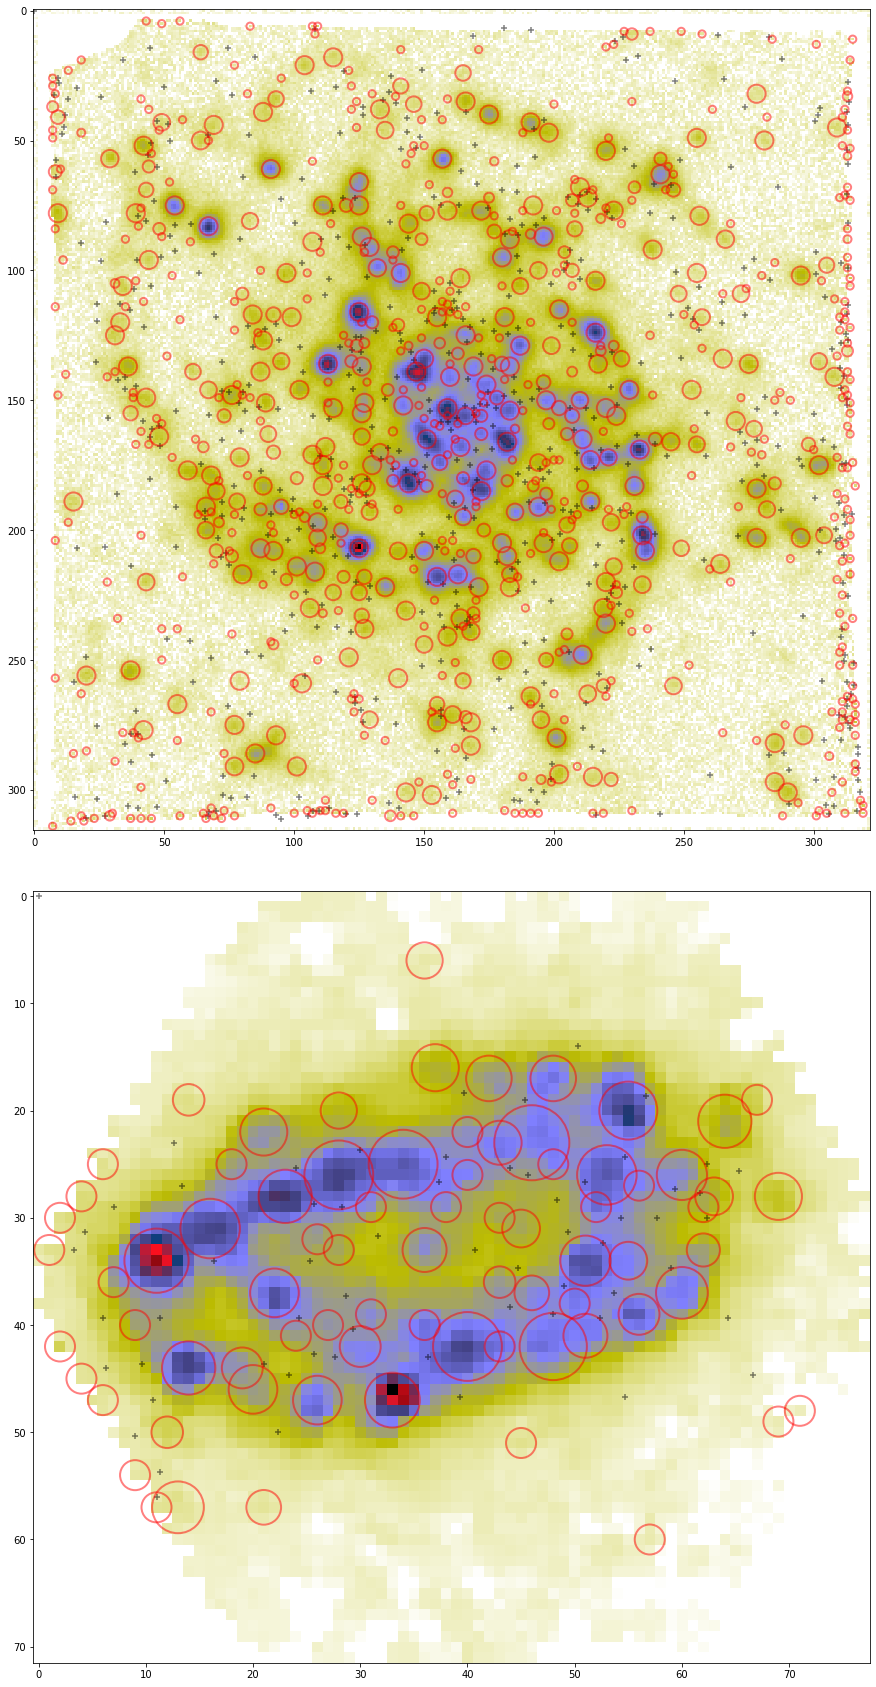

In [13]:
F_Ha_MUSE_g=gaussian_filter(F_Ha_MUSE, sigma=20*FWHM_MUSE)
mask_MUSE = F_Ha_MUSE_g<2*MUSE_1sig
F_Ha_MUSE_masked = np.ma.array(F_Ha_MUSE, mask = mask_MUSE, fill_value=0.0)
F_Ha_MUSE_fill = F_Ha_MUSE_masked.filled()

F_Ha_CAL_g=gaussian_filter(F_Ha_CAL, sigma=20*FWHM_CAL)
mask_CAL = F_Ha_CAL_g<2*CAL_1sig
F_Ha_CAL_masked = np.ma.array(F_Ha_CAL, mask = mask_CAL, fill_value=0.0)
F_Ha_CAL_fill = F_Ha_CAL_masked.filled()


#print(F_Ha_MUSE_masked)

fig, axes = plt.subplots(2,1, figsize=(12,24))
#fig, axes = plt.subplots(1,2, figsize=(12,6))

cmap='gist_stern_r'
axes[0].imshow(np.sqrt(F_Ha_MUSE), interpolation='none',\
               cmap=cmap) 
               #vmin=-0.5*MUSE_1sig, vmax=300*MUSE_1sig)
axes[1].imshow(np.sqrt(F_Ha_CAL), interpolation='none',\
               cmap=cmap)
#, vmin=-0.5*CAL_1sig, vmax=300*CAL_1sig)
#axes[1].imshow(F_Ha_CAL, interpolation='none', cmap='viridis')

#blobs_log_MUSE = blob_log(F_Ha_MUSE_fill, min_sigma=1, max_sigma=3, num_sigma=100, threshold=.01)
print(FWHM_MUSE)
blobs_log_MUSE = blob_log(F_Ha_MUSE_fill, min_sigma=0.8,\
                          max_sigma=2.0,\
                          num_sigma=30, threshold=2*MUSE_1sig)
#blobs_log_MUSE = blob_log(F_Ha_MUSE_fill, min_sigma=1,\
#                          max_sigma=2.0,\
#                          num_sigma=3, threshold=1.5*MUSE_1sig)

blobs_log_MUSE[:, 2] = blobs_log_MUSE[:, 2] * 1.75 #sqrt(2)
print('# HIIreg MUSE=',len(blobs_log_MUSE))
EW_Ha_HII_MUSE = diff_p_MUSE = np.zeros((len(blobs_log_MUSE),2))
for blob in blobs_log_MUSE:
        y, x, r = blob
        c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False, alpha=0.5)
        val = F_Ha_MUSE_masked[np.int(y),np.int(x)]
        val_g = F_Ha_MUSE_g[np.int(y),np.int(x)]
        axes[0].add_patch(c)

#
# Diffuse points
#
points_MUSE = blobs_log_MUSE[:,0:2]
tri_MUSE = Delaunay(points_MUSE)
diff_p_MUSE = np.zeros((len(tri_MUSE.simplices),2))
print ("# = ",len(blobs_log_MUSE),len(tri_MUSE.simplices))
#diff_p_MUSE = np.zeros((len(blobs_log_MUSE),2))
for j, s in enumerate(tri_MUSE.simplices):
    p = points_MUSE[s].mean(axis=0)
    diff_p_MUSE[s,1]=p[0]
    diff_p_MUSE[s,0]=p[1]
diff_p_MUSE = unique2d(diff_p_MUSE)
print ("# = ",len(diff_p_MUSE))
#diff_p_MUSE = np.unique(diff_p_MUSE)
axes[0].scatter(diff_p_MUSE[:,0],diff_p_MUSE[:,1],marker='+',color='black', alpha=0.5)
        
        
blobs_log_CAL = blob_log(F_Ha_CAL_fill, min_sigma=0.8,\
                         max_sigma=2.0,\
                         num_sigma=30, threshold=1.5*CAL_1sig)
blobs_log_CAL[:, 2] = blobs_log_CAL[:, 2] * 1.75 # sqrt(2)
print('# HIIreg CAL=',len(blobs_log_CAL))
for blob in blobs_log_CAL:
        y, x, r = blob
        c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False, alpha=0.5)
        axes[1].add_patch(c)
#
# Diffuse points
#
points_CAL = blobs_log_CAL[:,0:2]
tri_CAL = Delaunay(points_CAL)
diff_p_CAL = np.zeros((len(tri_CAL.simplices),2))
for j, s in enumerate(tri_CAL.simplices):
    p = points_CAL[s].mean(axis=0)
    diff_p_CAL[s,1]=p[0]
    diff_p_CAL[s,0]=p[1]
diff_p_CAL = unique2d(diff_p_CAL)
axes[1].scatter(diff_p_CAL[:,0],diff_p_CAL[:,1],marker='+',color='black', alpha=0.5)
#axes.set_title(str(interp_method))

plt.tight_layout()
plt.show()

In [14]:
FWHM = 1.2 # ARCSEC
pix_scale = 0.2 # ARCSEC
FWHM_pix = FWHM/pix_scale
scale_factor = 3*FWHM_pix
FWHM_pix_sc = scale_factor*FWHM_pix
(ny,nx)=F_Ha_MUSE.shape
nx_s = np.int(scale_factor*nx)
ny_s = np.int(scale_factor*ny)

sc_F_Ha_MUSE = np.array(Image.fromarray(F_Ha_MUSE).resize((nx_s,ny_s),resample =PIL.Image.LANCZOS))
sc_eF_Ha_MUSE = np.array(Image.fromarray(eF_Ha_MUSE).resize((nx_s,ny_s),resample =PIL.Image.LANCZOS))


fig, axes = plt.subplots(1,2, figsize=(12, 6))

axes[0].imshow(F_Ha_MUSE, interpolation='none', cmap='viridis')
axes[0].set_xlim(0,nx)
axes[0].set_ylim(0,ny)


axes[1].imshow(sc_F_Ha_MUSE, interpolation='none', cmap='viridis')
axes[1].set_xlim(0,nx_s)
axes[1].set_ylim(0,ny_s)

#axes.set_title(str(interp_method))

plt.tight_layout()
plt.show()

#sc_F_Ha_MUSE = sp.misc.imresize(F_Ha_MUSE,scale_factor,interp='lanczos')

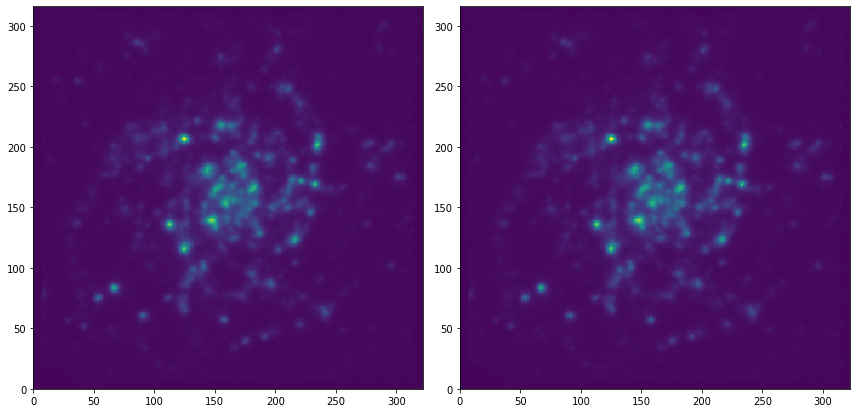

In [15]:
x, y = np.meshgrid(np.linspace(-3*FWHM_pix,3*FWHM_pix,np.int(6*FWHM_pix)), \
                   np.linspace(-3*FWHM_pix,3*FWHM_pix,np.int(6*FWHM_pix)))

d = np.sqrt(x*x+y*y)
sigma, mu = 0.02*FWHM_pix/2.354, 0.0
g = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )
F_Ha_MUSE_cor = correlate(F_Ha_MUSE,g)

fig, axes = plt.subplots(1,2, figsize=(12, 6))

axes[0].imshow(F_Ha_MUSE, interpolation='none', cmap='viridis')
axes[0].set_xlim(0,nx)
axes[0].set_ylim(0,ny)


axes[1].imshow(F_Ha_MUSE_cor, interpolation='none', cmap='viridis')
axes[1].set_xlim(0,nx)
axes[1].set_ylim(0,ny)

#axes.set_title(str(interp_method))

plt.tight_layout()
plt.show()
#sp.ndimage.correlate(input, weights, output=None, mode='reflect', cval=0.0, origin=0)[source]

In [16]:
(nx,ny)=F_Ha_CAL.shape
print(nx,ny)

72 78


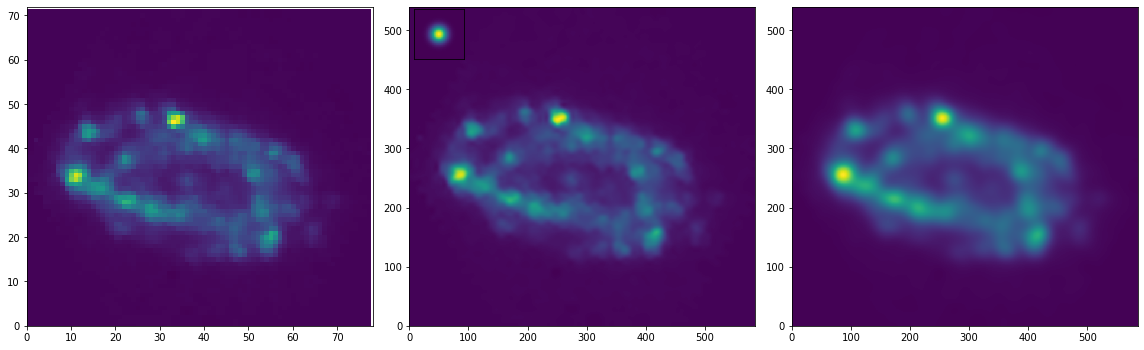

In [17]:
FWHM = 2.5 # ARCSEC
pix_scale = 1 # ARCSEC
FWHM_pix = FWHM/pix_scale

scale_factor = 3*FWHM_pix
FWHM_pix_sc = scale_factor*FWHM_pix
(ny,nx)=F_Ha_CAL.shape
nx_s = np.int(scale_factor*nx)
ny_s = np.int(scale_factor*ny)

sc_F_Ha_CAL = np.array(Image.fromarray(F_Ha_CAL).resize((nx_s,ny_s),resample =PIL.Image.LANCZOS))



n_fov=4
n_g=np.int(n_fov*FWHM_pix_sc)
x, y = np.meshgrid(np.linspace(-0.5*n_g,0.5*n_g,n_g), \
                    np.linspace(-0.5*n_g,0.5*n_g,n_g))
#                   np.linspace(-3*FWHM_pix,3*FWHM_pix,np.int(6*FWHM_pix)))

d = np.sqrt(x*x+y*y)
sigma, mu = FWHM_pix_sc/2.354, 0.0
g = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )
sc_F_Ha_CAL_cor = correlate(sc_F_Ha_CAL,g)

fig, axes = plt.subplots(1,3, figsize=(16, 5))

axes[0].imshow(F_Ha_CAL, interpolation='none', cmap='viridis')
axes[0].set_xlim(0,nx)
axes[0].set_ylim(0,ny)

axes[1].imshow(sc_F_Ha_CAL, interpolation='none', cmap='viridis')
axes[1].set_xlim(0,nx_s)
axes[1].set_ylim(0,ny_s)

axes[2].imshow(sc_F_Ha_CAL_cor, interpolation='none', cmap='viridis')
axes[2].set_xlim(0,nx_s)
axes[2].set_ylim(0,ny_s)

ax3 = fig.add_axes([0.32, 0.8, 1.0*n_g/nx_s, 1.0*n_g/ny_s])
ax3.imshow(g, interpolation='none', cmap='viridis')
ax3.set_xlim(0,n_g)
ax3.set_ylim(0,n_g)
#axes.set_title(str(interp_method))
ax3.axes.get_xaxis().set_visible(False)
ax3.axes.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()
#sp.ndimage.correlate(input, weights, output=None, mode='reflect', cval=0.0, origin=0)[source]

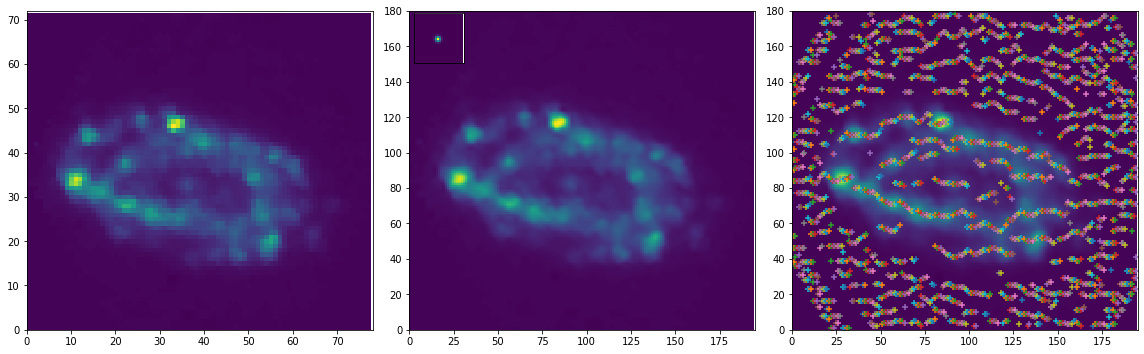

In [18]:
from scipy import ndimage
from scipy.signal import find_peaks

FWHM = 2.5 # ARCSEC
pix_scale = 1 # ARCSEC
FWHM_pix = FWHM/pix_scale

scale_factor = 1.0*FWHM_pix
FWHM_pix_sc = scale_factor*FWHM_pix
(ny,nx)=F_Ha_CAL.shape
nx_s = np.int(scale_factor*nx)
ny_s = np.int(scale_factor*ny)

sc_F_Ha_CAL = np.array(Image.fromarray(F_Ha_CAL).resize((nx_s,ny_s),resample =PIL.Image.LANCZOS))



n_fov=4
n_g=np.int(n_fov*FWHM_pix_sc)
x, y = np.meshgrid(np.linspace(-0.5*n_g,0.5*n_g,n_g), \
                    np.linspace(-0.5*n_g,0.5*n_g,n_g))
#                   np.linspace(-3*FWHM_pix,3*FWHM_pix,np.int(6*FWHM_pix)))

d = np.sqrt(x*x+y*y)
sigma, mu = FWHM_pix_sc/2.354, 0.0
g = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )
g = g**8
g = g - 0.001*np.max(g)
#sc_F_Ha_CAL_cor = ndimage.convolve(sc_F_Ha_CAL, g, mode='constant', cval=0.0)
sc_F_Ha_CAL_cor = correlate(sc_F_Ha_CAL,g)

fig, axes = plt.subplots(1,3, figsize=(16, 5))

axes[0].imshow(F_Ha_CAL, interpolation='none', cmap='viridis')
axes[0].set_xlim(0,nx)
axes[0].set_ylim(0,ny)

axes[1].imshow(sc_F_Ha_CAL, interpolation='none', cmap='viridis')
axes[1].set_xlim(0,nx_s)
axes[1].set_ylim(0,ny_s)

axes[2].imshow(sc_F_Ha_CAL_cor, interpolation='none', cmap='viridis')
axes[2].set_xlim(0,nx_s)
axes[2].set_ylim(0,ny_s)

for i in range(nx_s):
    col = sc_F_Ha_CAL_cor[:,i]
    y_peaks, _ = find_peaks(col)
    x_peaks = i+0.0*y_peaks
    axes[2].scatter(x_peaks,y_peaks,marker="+")
ax3 = fig.add_axes([0.32, 0.8, 1.0*n_g/nx_s, 1.0*n_g/ny_s])
ax3.imshow(g, interpolation='none', cmap='viridis')
ax3.set_xlim(0,n_g)
ax3.set_ylim(0,n_g)
#axes.set_title(str(interp_method))
ax3.axes.get_xaxis().set_visible(False)
ax3.axes.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()
#sp.ndimage.correlate(input, weights, output=None, mode='reflect', cval=0.0, origin=0)[source]

In [19]:
import scipy
print(scipy.__version__)

1.5.2


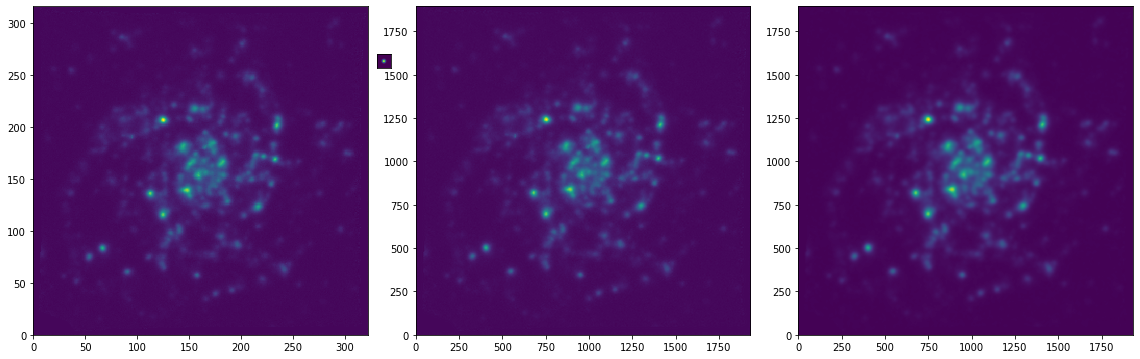

In [20]:
from scipy import ndimage
FWHM = 1.2 # ARCSEC
pix_scale = 0.2 # ARCSEC
FWHM_pix = FWHM/pix_scale

scale_factor = FWHM_pix
FWHM_pix_sc = scale_factor*FWHM_pix
(ny,nx)=F_Ha_MUSE.shape
nx_s = np.int(scale_factor*nx)
ny_s = np.int(scale_factor*ny)

sc_F_Ha_MUSE = np.array(Image.fromarray(F_Ha_MUSE).resize((nx_s,ny_s),resample =PIL.Image.LANCZOS))



n_fov=2
n_g=np.int(n_fov*FWHM_pix_sc)
x, y = np.meshgrid(np.linspace(-0.5*n_g,0.5*n_g,n_g), \
                    np.linspace(-0.5*n_g,0.5*n_g,n_g))
#                   np.linspace(-3*FWHM_pix,3*FWHM_pix,np.int(6*FWHM_pix)))

d = np.sqrt(x*x+y*y)
sigma, mu = FWHM_pix_sc/2.354, 0.0
g = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )
g = g**8
g = g - 0.001*np.max(g)
#sc_F_Ha_MUSE_cor = ndimage.convolve(sc_F_Ha_MUSE, g, mode='constant', cval=0.0)
sc_F_Ha_MUSE_cor = correlate(sc_F_Ha_MUSE,g)

fig, axes = plt.subplots(1,3, figsize=(16, 5))

axes[0].imshow(F_Ha_MUSE, interpolation='none', cmap='viridis')
axes[0].set_xlim(0,nx)
axes[0].set_ylim(0,ny)

axes[1].imshow(sc_F_Ha_MUSE, interpolation='none', cmap='viridis')
axes[1].set_xlim(0,nx_s)
axes[1].set_ylim(0,ny_s)

axes[2].imshow(sc_F_Ha_MUSE_cor, interpolation='none', cmap='viridis')
axes[2].set_xlim(0,nx_s)
axes[2].set_ylim(0,ny_s)

ax3 = fig.add_axes([0.32, 0.8, 1.0*n_g/nx_s, 1.0*n_g/ny_s])
ax3.imshow(g, interpolation='none', cmap='viridis')
ax3.set_xlim(0,n_g)
ax3.set_ylim(0,n_g)
#axes.set_title(str(interp_method))
ax3.axes.get_xaxis().set_visible(False)
ax3.axes.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()
#sp.ndimage.correlate(input, weights, output=None, mode='reflect', cval=0.0, origin=0)[source]

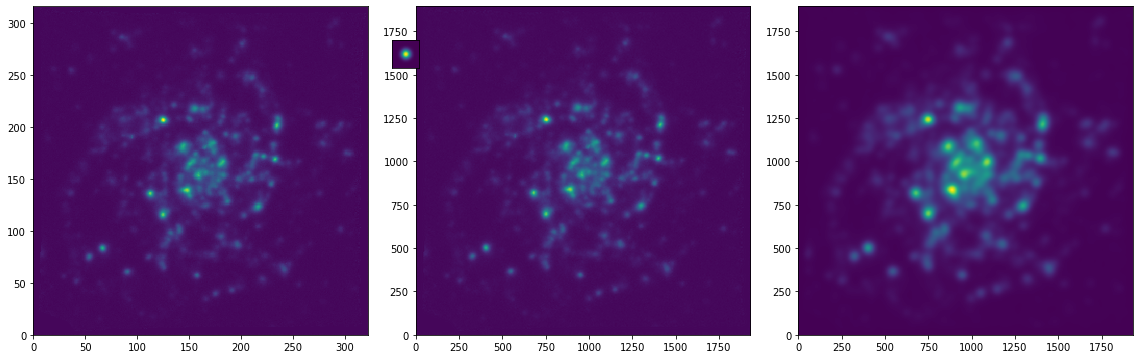

In [21]:
FWHM = 1.2 # ARCSEC
pix_sMUSEe = 0.2 # ARCSEC
FWHM_pix = FWHM/pix_sMUSEe

sMUSEe_factor = 1*FWHM_pix
FWHM_pix_sc = sMUSEe_factor*FWHM_pix
(ny,nx)=F_Ha_MUSE.shape
nx_s = np.int(sMUSEe_factor*nx)
ny_s = np.int(sMUSEe_factor*ny)

sc_F_Ha_MUSE = np.array(Image.fromarray(F_Ha_MUSE).resize((nx_s,ny_s),resample =PIL.Image.LANCZOS))



n_fov=4
n_g=np.int(n_fov*FWHM_pix_sc)
x, y = np.meshgrid(np.linspace(-0.5*n_g,0.5*n_g,n_g), \
                    np.linspace(-0.5*n_g,0.5*n_g,n_g))
#                   np.linspace(-3*FWHM_pix,3*FWHM_pix,np.int(6*FWHM_pix)))

d = np.sqrt(x*x+y*y)
sigma, mu = FWHM_pix_sc/2.354, 0.0
g = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )
sc_F_Ha_MUSE_cor = correlate(sc_F_Ha_MUSE,g)

fig, axes = plt.subplots(1,3, figsize=(16, 5))

axes[0].imshow(F_Ha_MUSE, interpolation='none', cmap='viridis')
axes[0].set_xlim(0,nx)
axes[0].set_ylim(0,ny)

axes[1].imshow(sc_F_Ha_MUSE, interpolation='none', cmap='viridis')
axes[1].set_xlim(0,nx_s)
axes[1].set_ylim(0,ny_s)

axes[2].imshow(sc_F_Ha_MUSE_cor, interpolation='none', cmap='viridis')
axes[2].set_xlim(0,nx_s)
axes[2].set_ylim(0,ny_s)

ax3 = fig.add_axes([0.32, 0.8, 1.0*n_g/nx_s, 1.0*n_g/ny_s])
ax3.imshow(g, interpolation='none', cmap='viridis')
ax3.set_xlim(0,n_g)
ax3.set_ylim(0,n_g)
#axes.set_title(str(interp_method))
ax3.axes.get_xaxis().set_visible(False)
ax3.axes.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()
#sp.ndimage.correlate(input, weights, output=None, mode='reflect', cval=0.0, origin=0)[source]

In [22]:
print("DONE")

DONE


Start fitting HII Gaussians
Finish fitting HII Gaussians


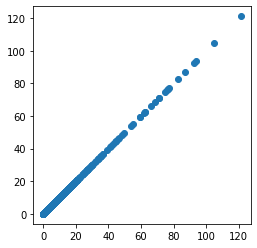

In [86]:
#def HII_image_to_fit(org_img,blobs,nx,ny,dr=5): 
#def HII_image_to_fit(blobs,nx,ny,dr=5): 
#x = np.arange(0,len(blobs_F_Ha),1)
(ny,nx) = F_Ha_MUSE.shape
x_g = np.arange(0,nx,1)
y_g = np.arange(0,ny,1)        
x_g, y_g = np.meshgrid(x_g, y_g) # get 2D variables instead of 1D
X = x_g + y_g * 1j
#print(X)
#print(nx,ny)
#print(len(X))
#print(F_Ha_MUSE.shape)
#x = np.arange(0,len(blobs_F_Ha),1)
#print(x_g.shape)
print('Start fitting HII Gaussians')
F_Ha_MUSE_clean=F_Ha_MUSE-diff_map_final

xdata = np.vstack((x_g.ravel(), y_g.ravel()))
#ydata = Z.ravel()

#leastsq, covar = curve_fit(ravel_HII_image_to_fit(blobs_final,nx,ny,dr=5),\
#                           xdata,F_Ha_MUSE_clean.ravel(),p0=blobs_F_Ha,\
#                           sigma=0.1*np.abs(F_Ha_MUSE_clean.ravel()))
#coeffs, coeffs_cov = curve_fit(fitfun, xdata, ydata)

#
# Definning global variables to fit 
#
BLOBS=blobs_final
NX=nx
NY=ny
DR=5
ydata=F_Ha_MUSE_clean.ravel()
leastsq, covar = curve_fit(ravel_Gauss_HII_img,\
                           xdata,ydata,p0=blobs_F_Ha)
#,\
#                           diag=(1./ydata.mean(),1./xdata.mean()))
#                           xdata,F_Ha_MUSE_clean.ravel(),p0=blobs_F_Ha*0.85,\
#                           sigma=0.1+0.1*np.abs(F_Ha_MUSE_clean.ravel()))
#def ravel_Gauss_HII_img(xdata, flux):

#leastsq, covar = curve_fit(flatten_HII_image_to_fit(blobs_final,nx,ny,dr=5),\
#                           X.flatten(),F_Ha_MUSE_clean.flatten(),p0=blobs_F_Ha)
#print(leastsq)
print('Finish fitting HII Gaussians')
#res = minimize(delta_HII_image_to_fit(F_Ha_MUSE,blobs_final,nx,ny,dr=5),x) 
#print (res.fun)
plt.scatter(blobs_F_Ha,leastsq)
plt.axes().set_aspect('equal', adjustable='box')